## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
!pip install nb-black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score
)

from sklearn.metrics import confusion_matrix

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To use statistical functions
import scipy.stats as stats

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Data Science- GL/6- Model Tuning/Project 6: Model Tuning : ReneWind/Train.csv')

In [ ]:
train.shape

(20000, 41)

- There are 20,000 rows and 41 attributes (including the predictor) in the dataset

## Data Overview

- Observations
- Sanity checks

In [ ]:
data = train.copy()

In [ ]:
# let's view the first 5 rows of the data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
# let's view the last 5 rows of the data
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


In [ ]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

- All attributes except "Target" have all unique values
- V1 and V2 have missing values

In [ ]:
# let's view the statistical summary of the numerical columns in the data
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


- The spread of attributes will be explored further (univariate analysis)

In [ ]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

- There is no duplicated values.

In [ ]:
# let's check for missing values in the data
data.isnull().sum() 

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

- V1 and V2 columns have 18 missing values.

## Univariate Analysis

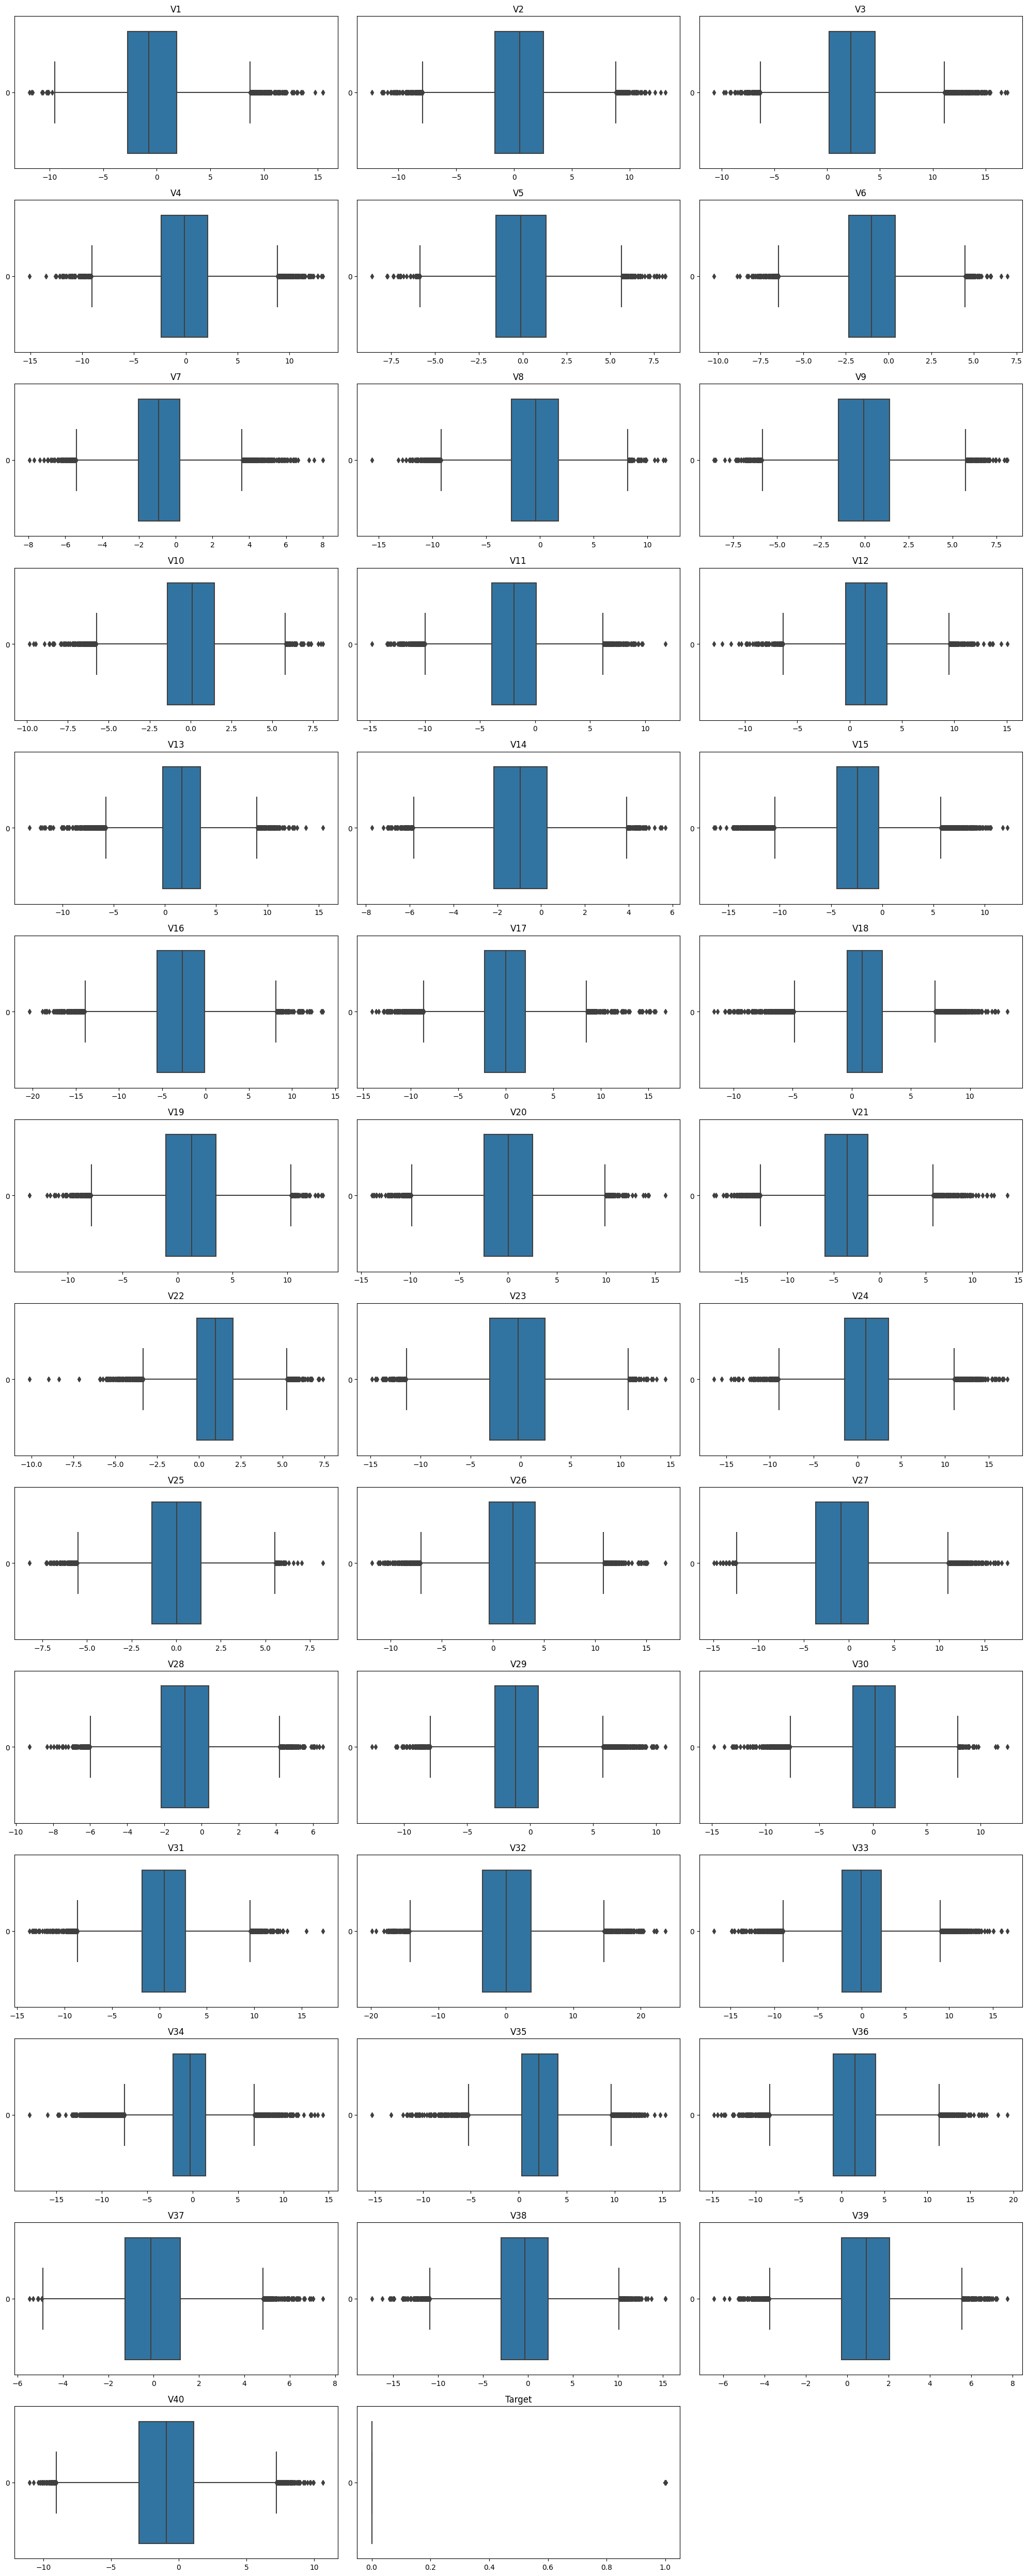

In [ ]:
cols = data.columns.tolist()

plt.figure(figsize=(20, 50))
for i, variable in enumerate(cols):
    plt.subplot(14, 3, i + 1)
    sns.boxplot(data[variable],orient="h")
    plt.tight_layout()
    plt.title(variable)
plt.show()

- There are positive and negative outliers for all attributes "V1" to "V40". The scale of attributes are more or less the same (somewhere between -20 to +20). Since not much is known about the attributes, the outliers will not be treated and are assumed to be real data trends

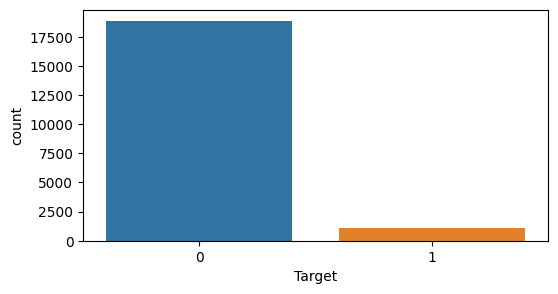

0    18890
1     1110
Name: Target, dtype: int64

In [ ]:
plt.figure(figsize=(6, 3))
sns.countplot(x=data["Target"]);
plt.show()
data["Target"].value_counts()

- "Target" class is imbalanced with 18890 or %94.45 "No failures (i.e., 0)" and 1110 or %5.55 "Failures (i.e., 1)"

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

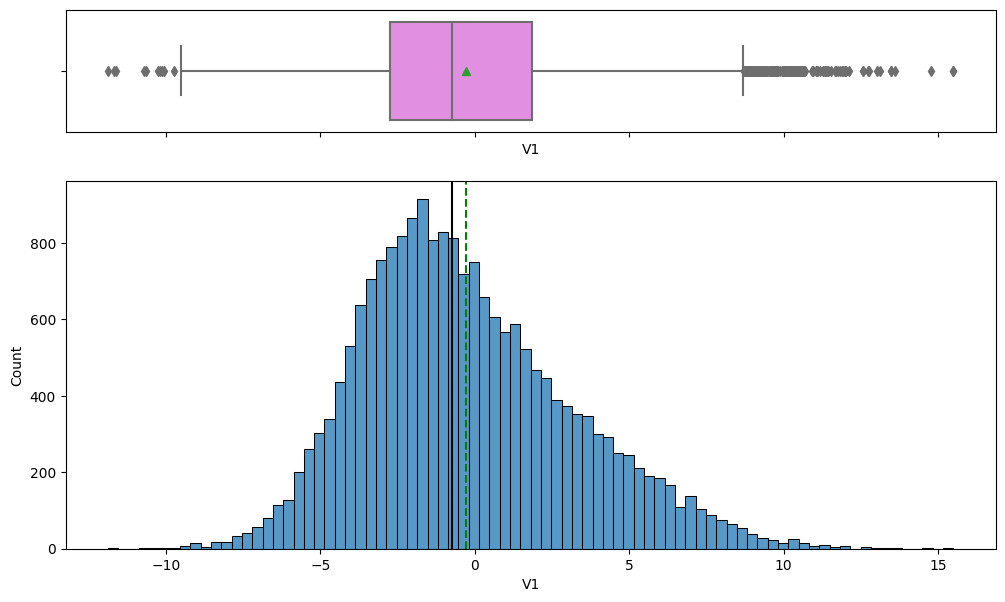

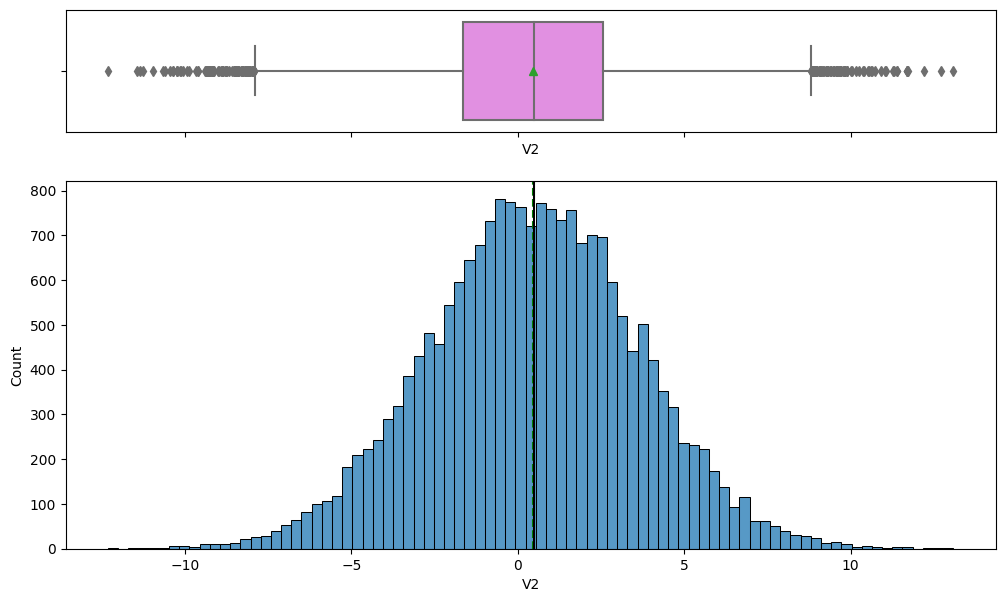

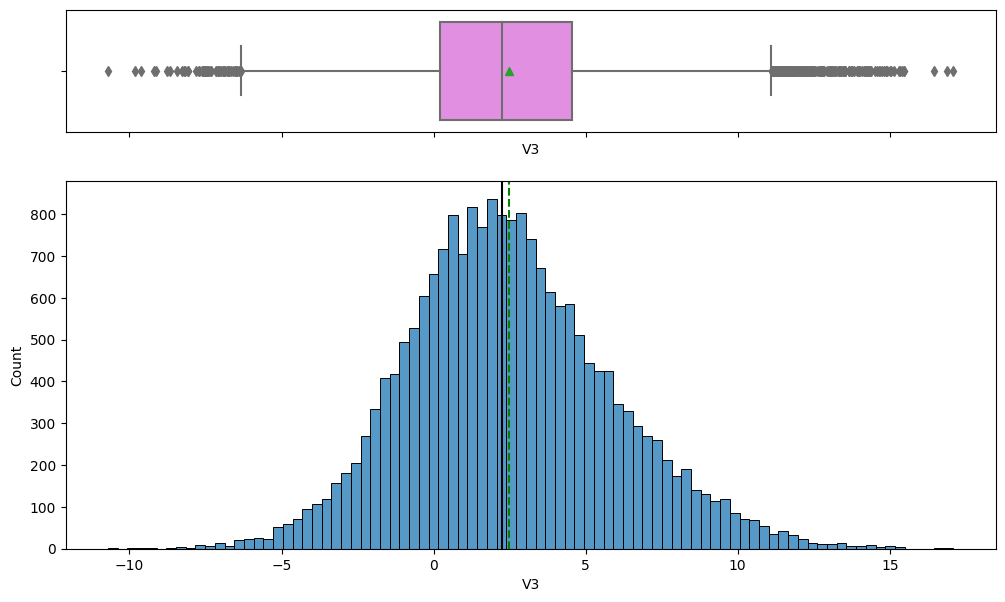

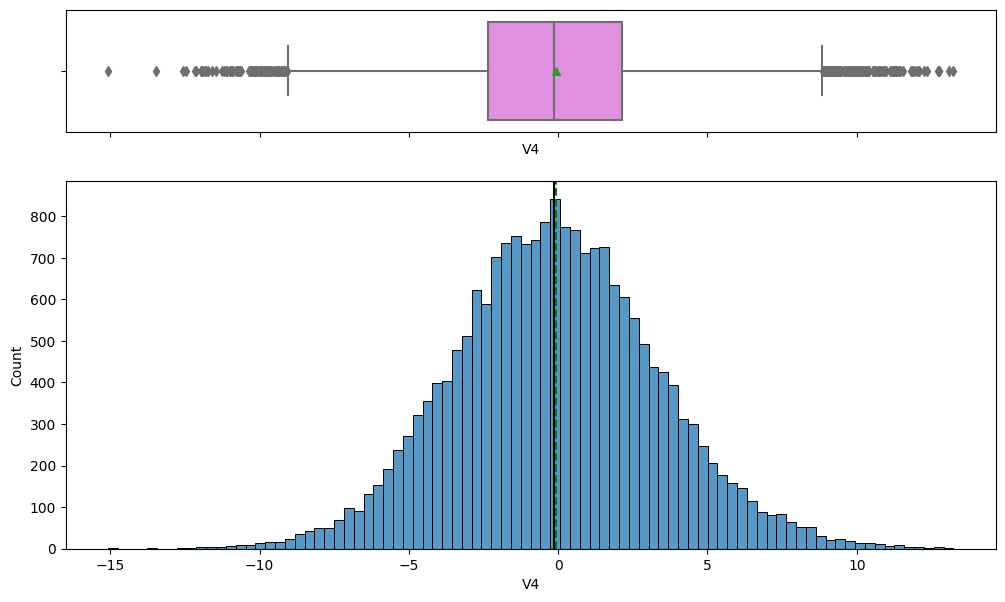

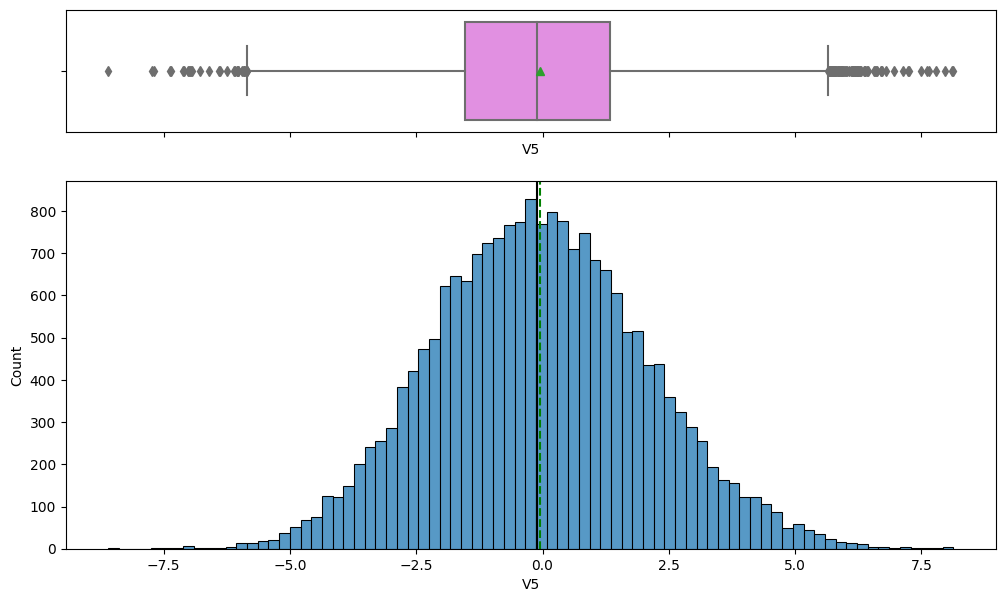

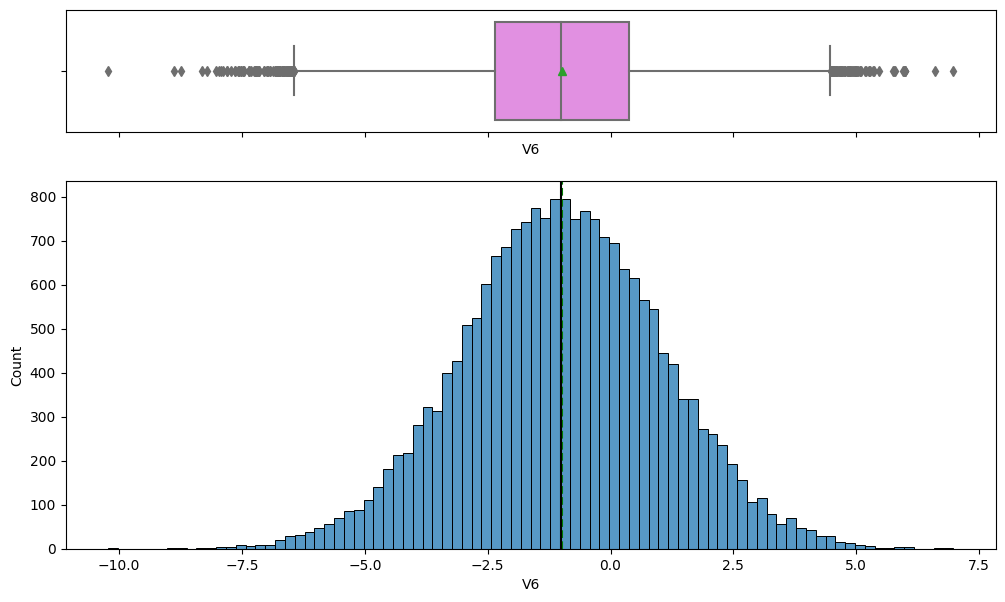

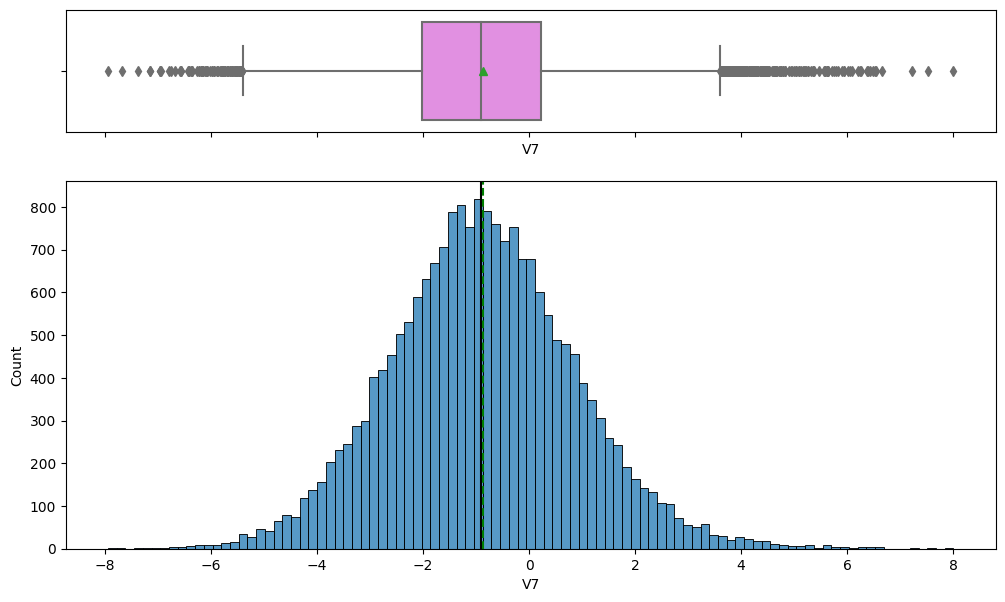

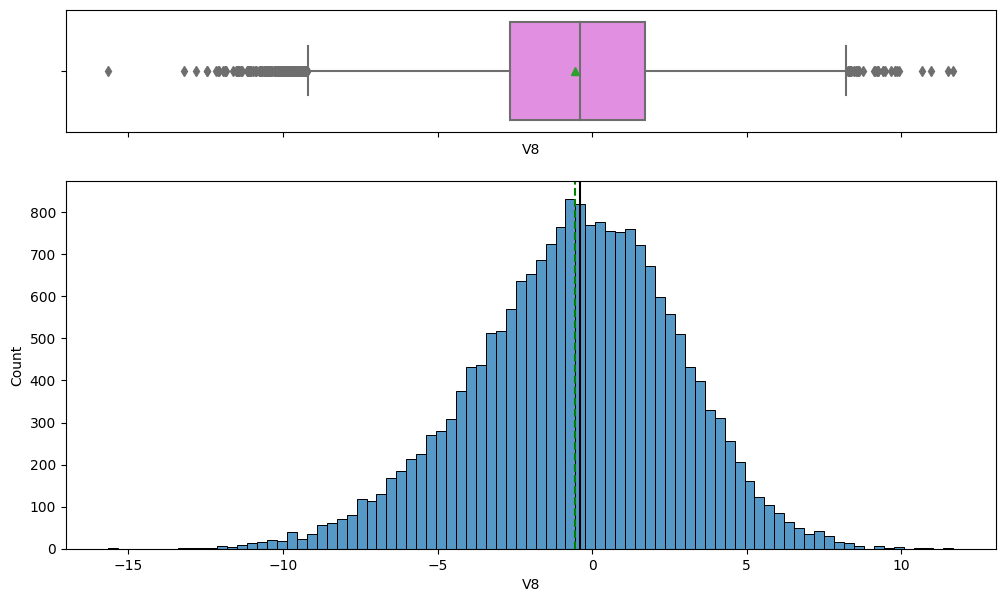

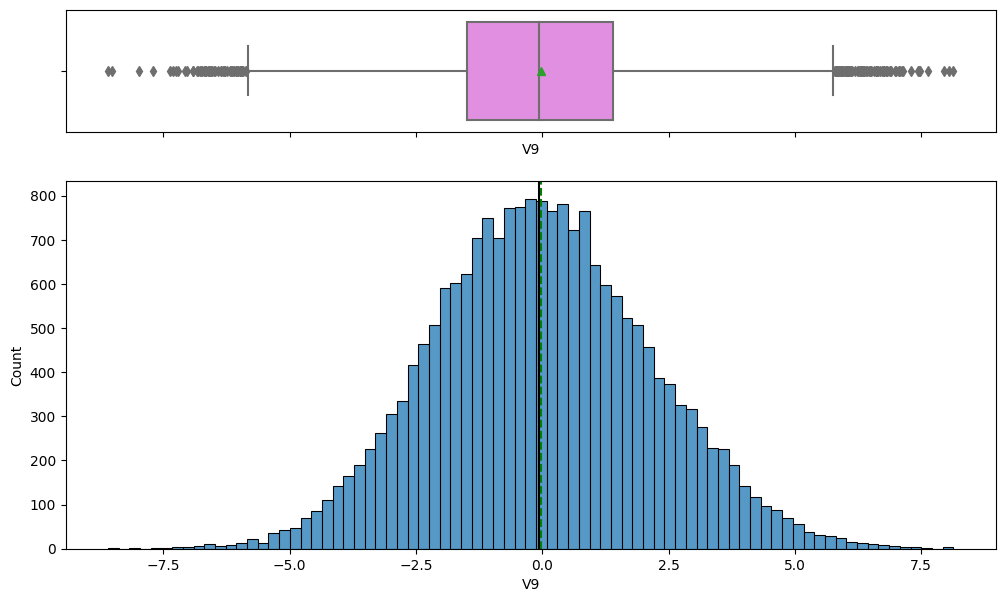

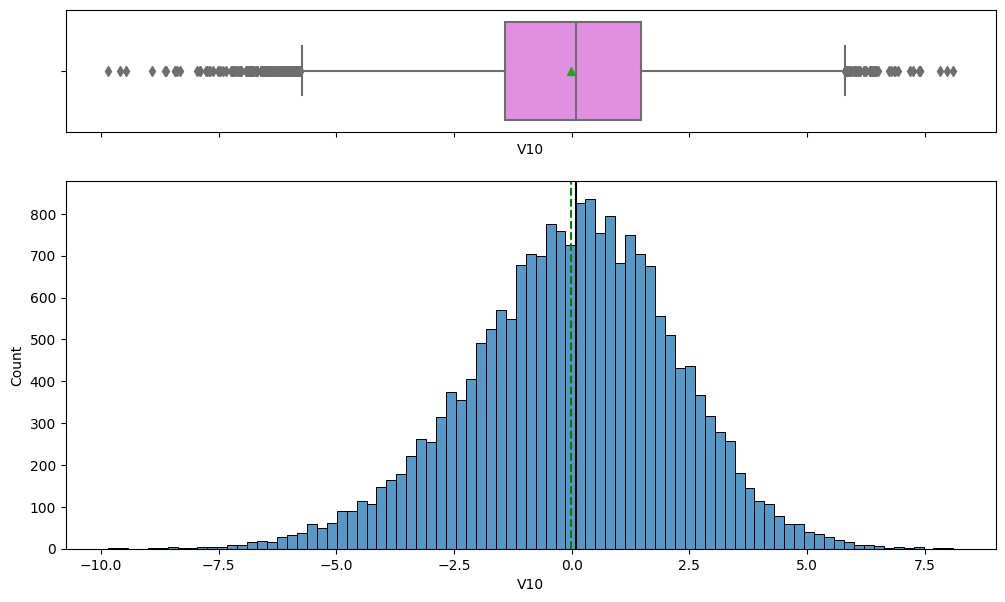

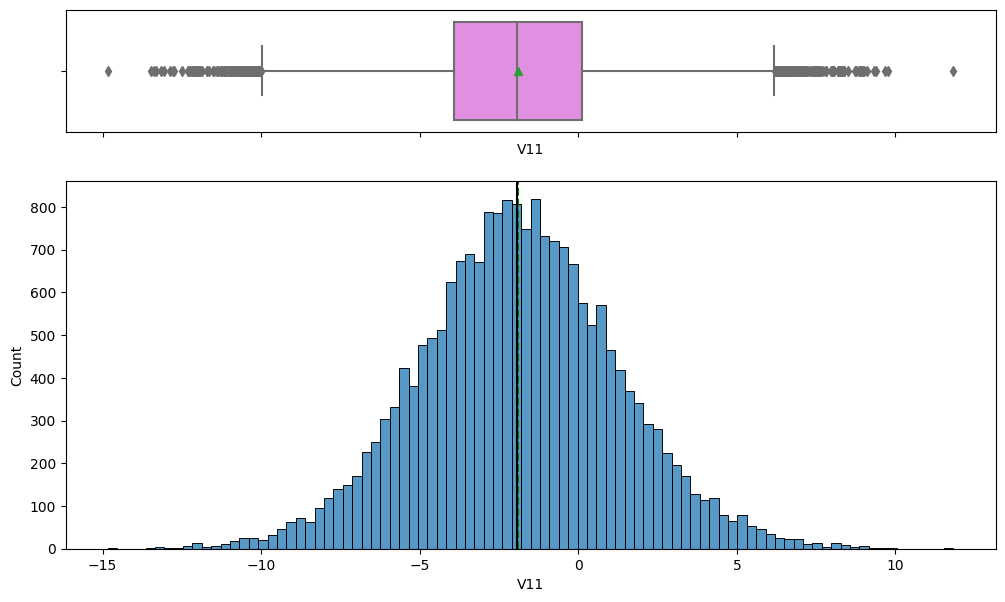

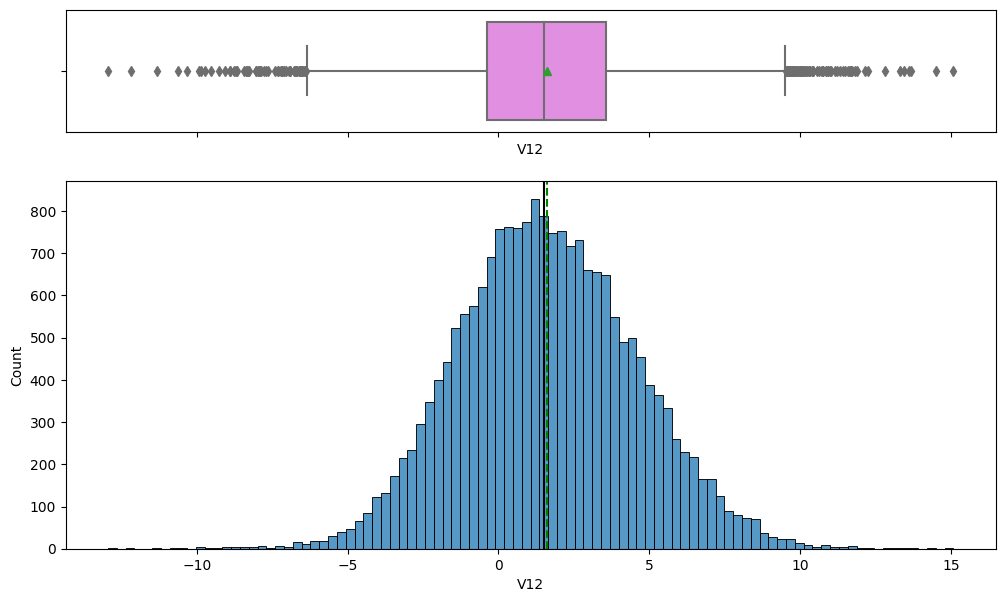

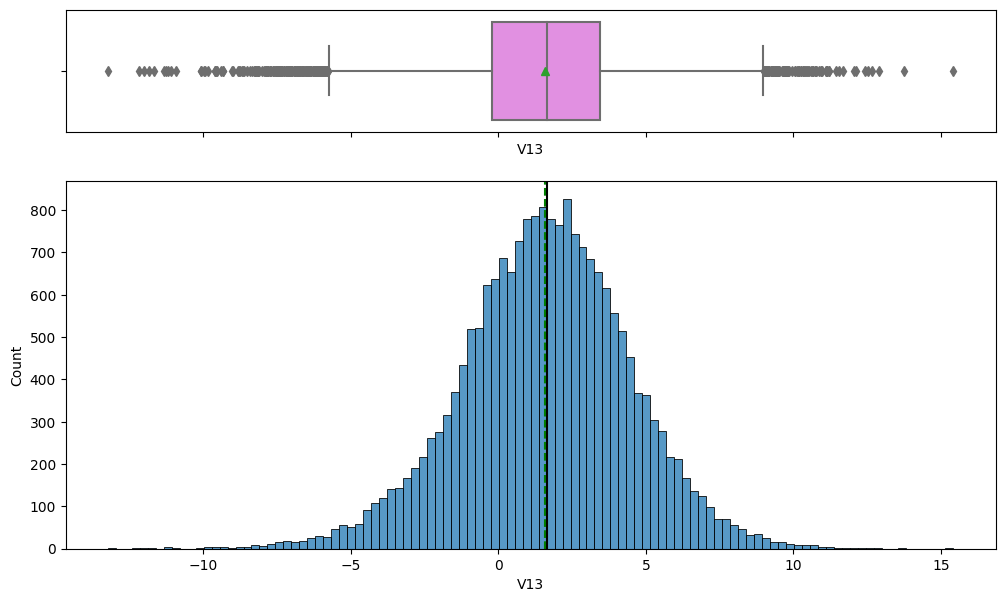

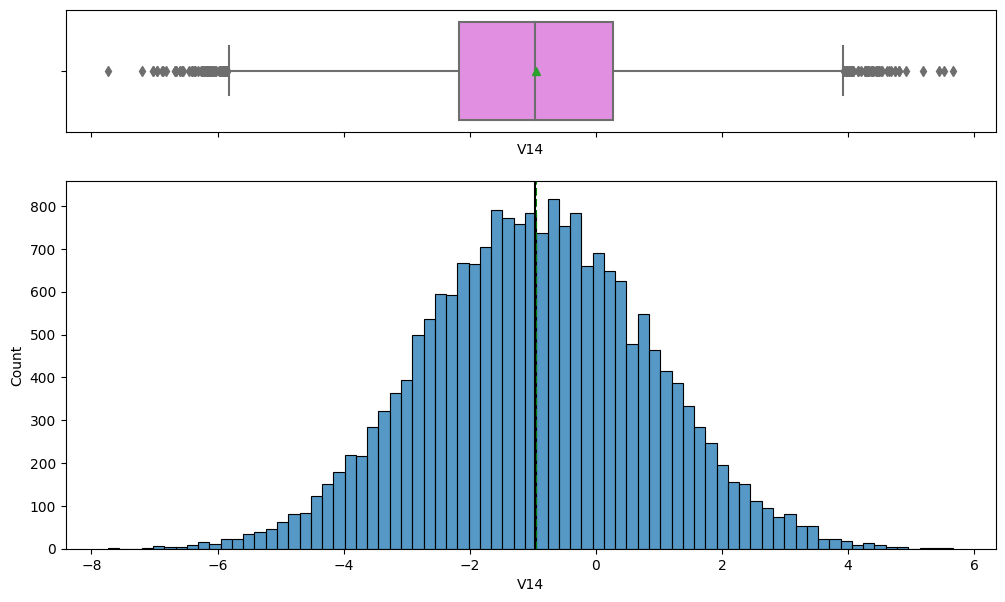

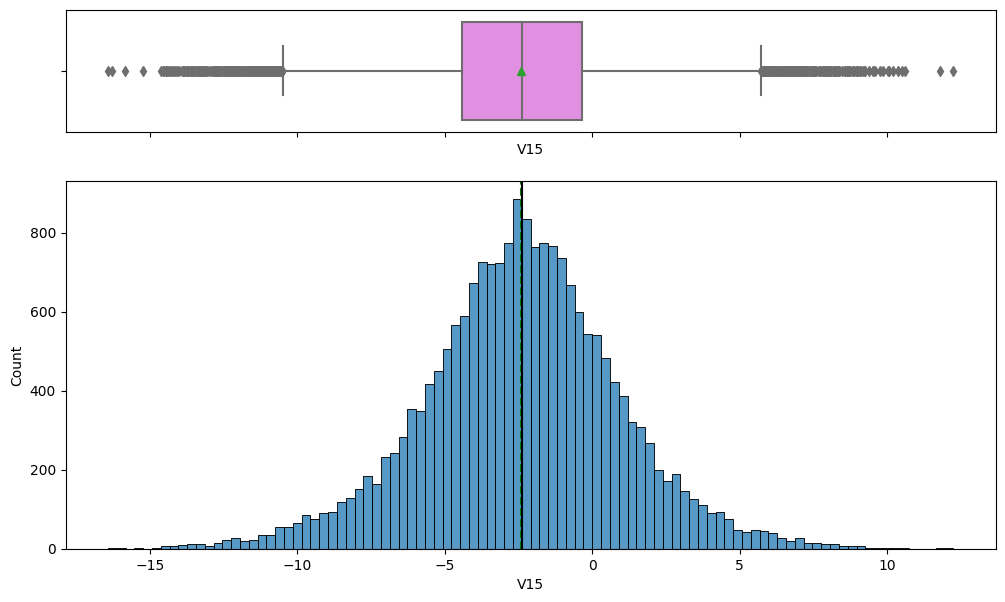

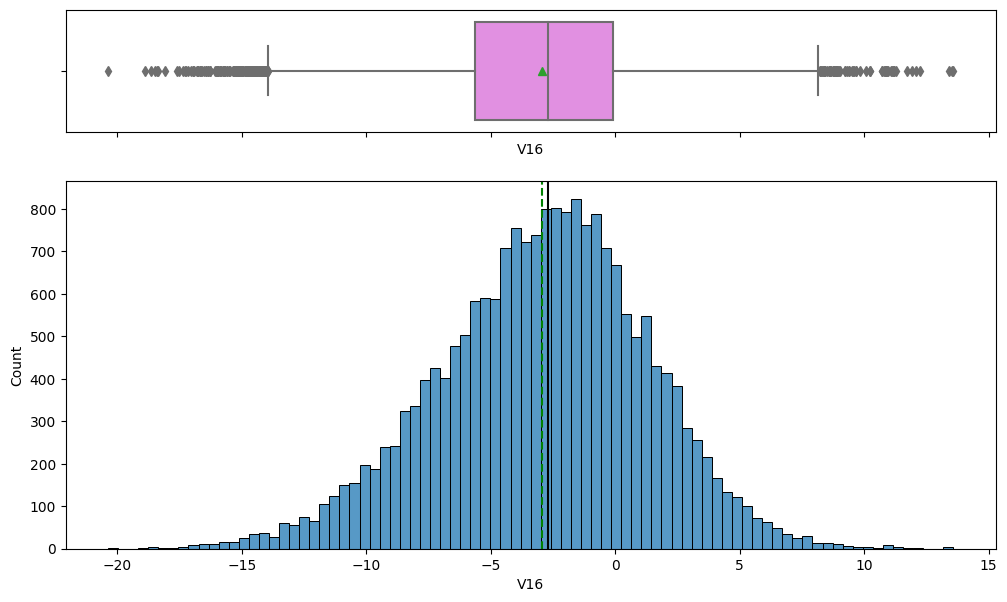

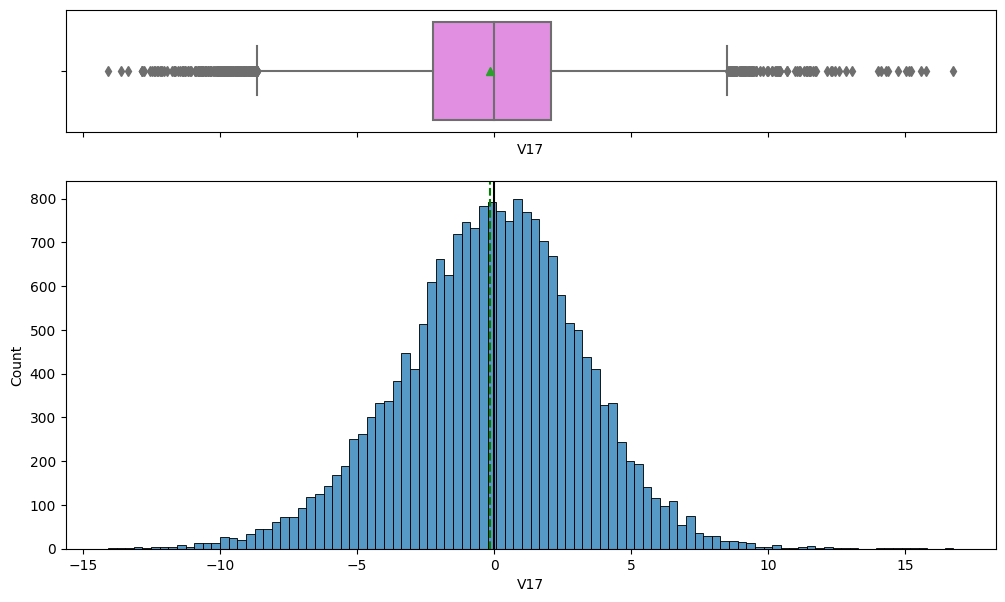

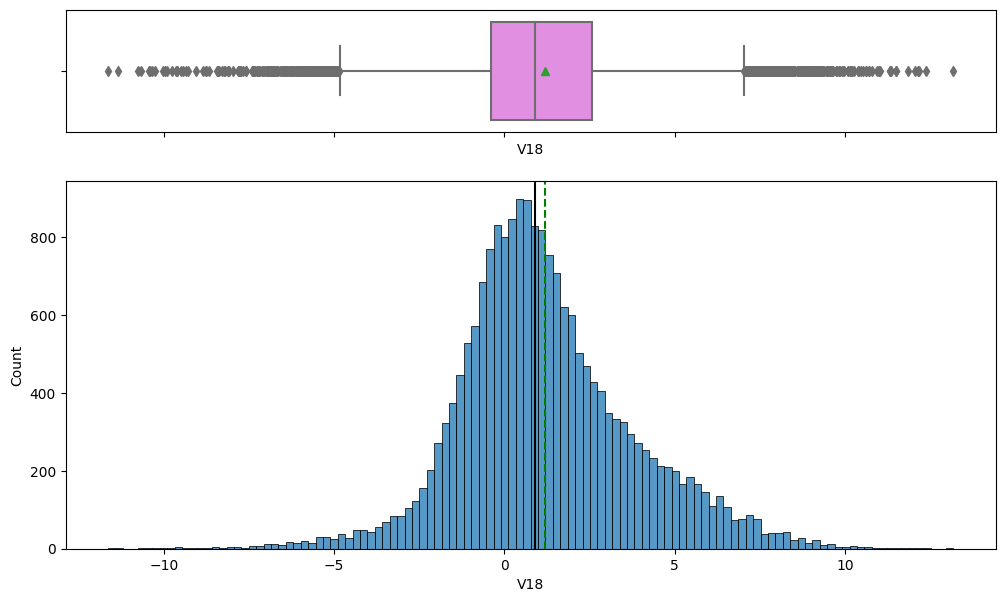

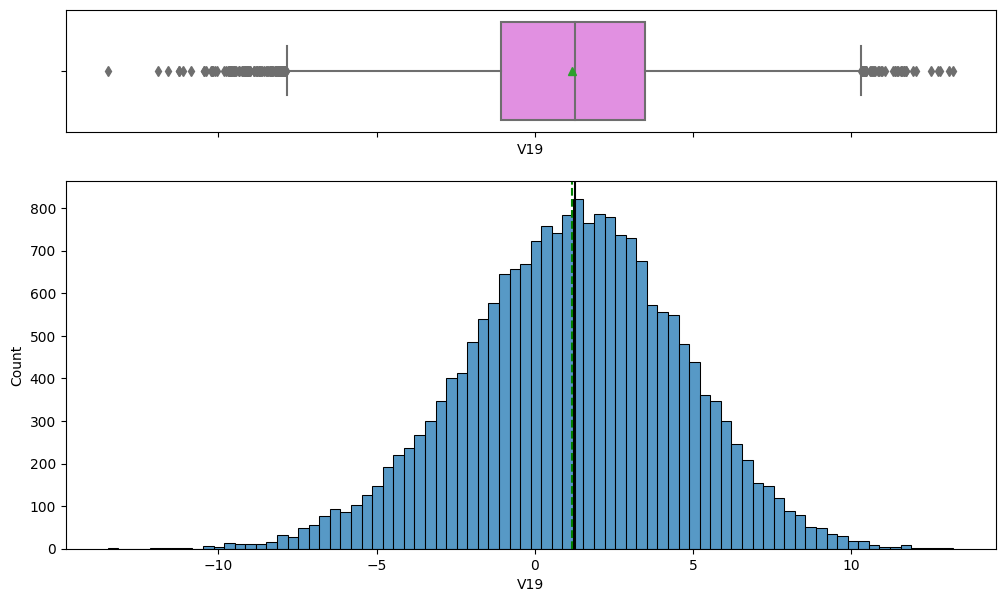

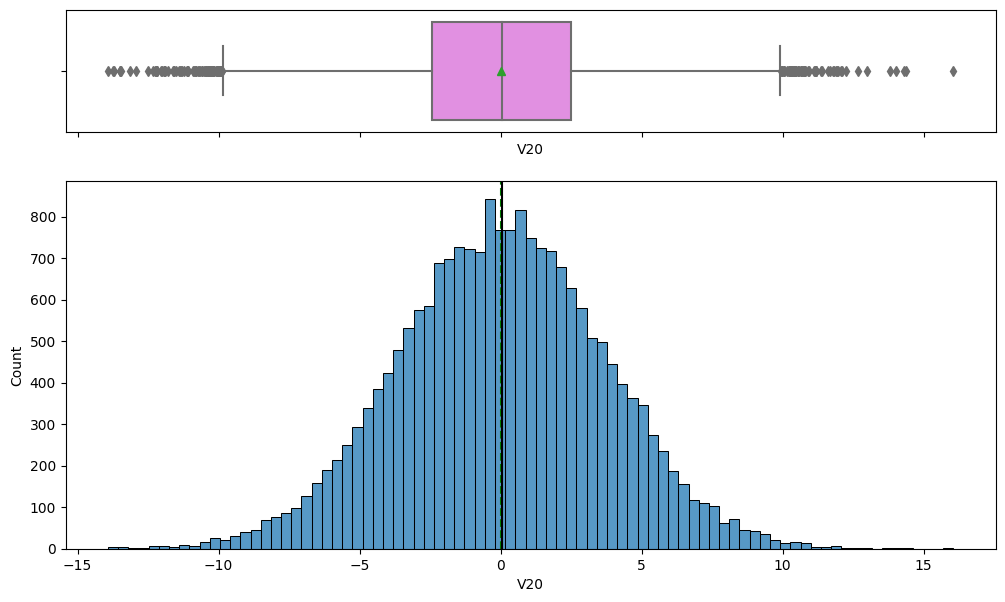

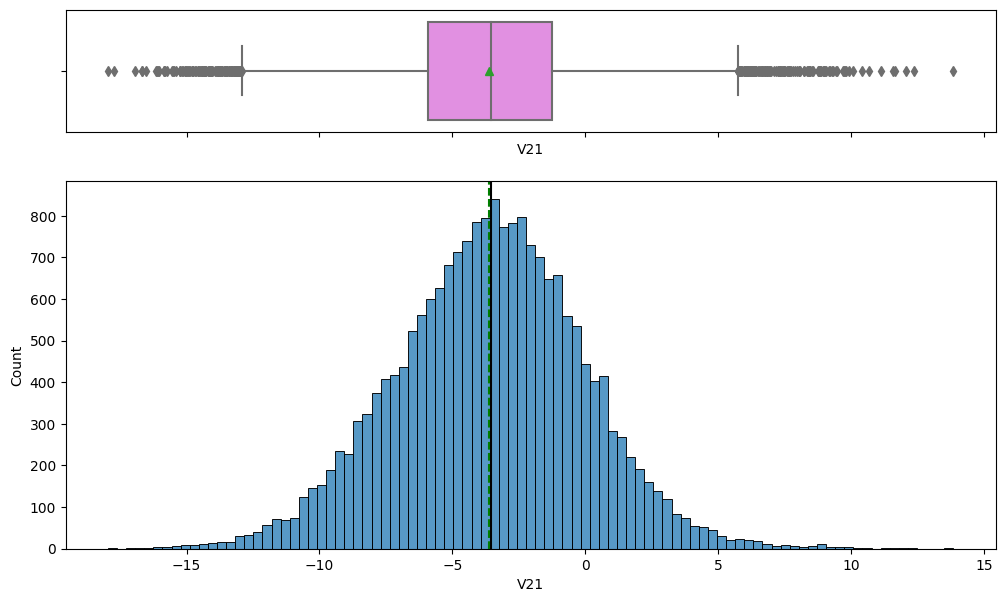

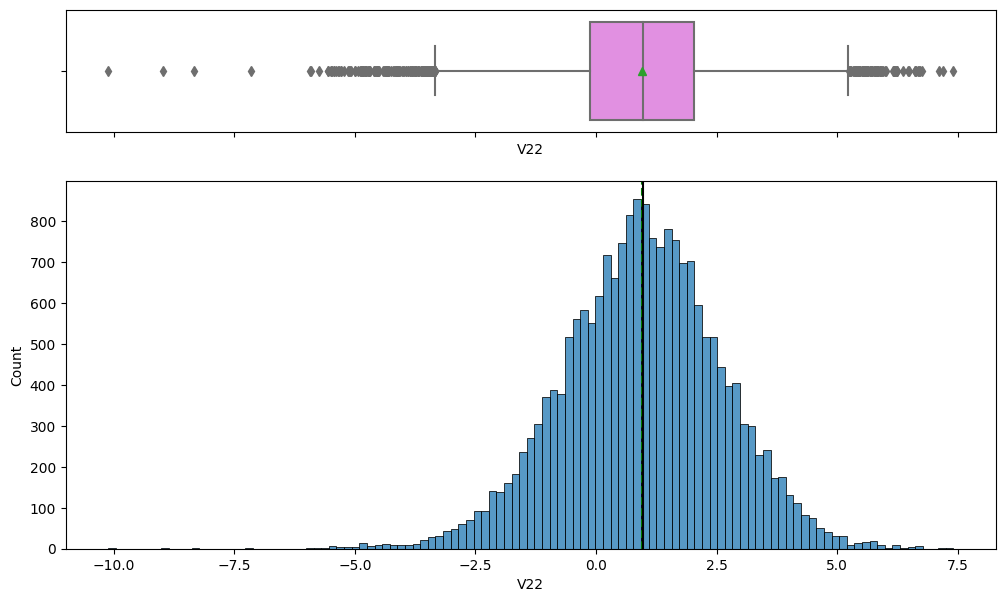

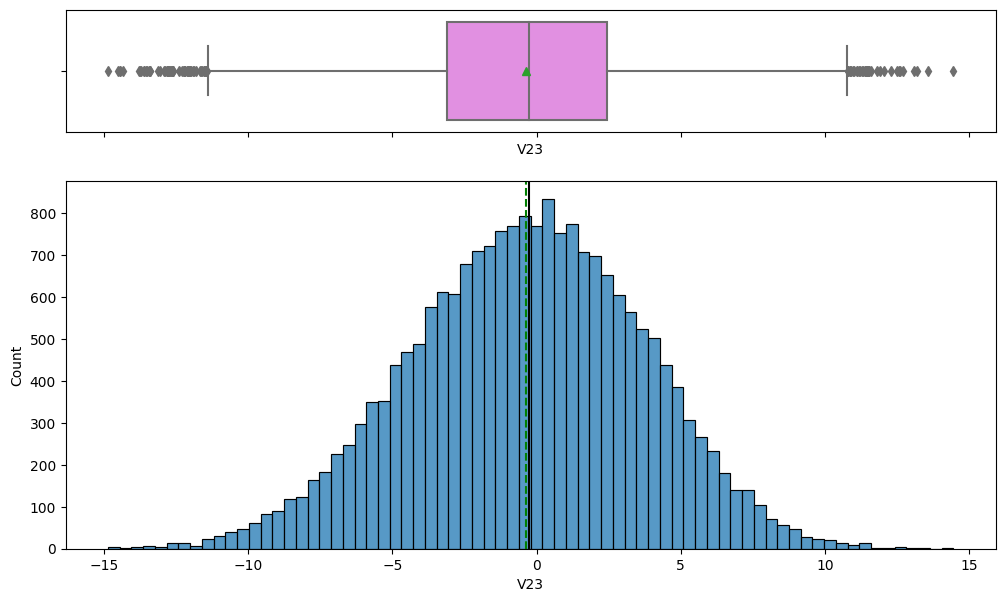

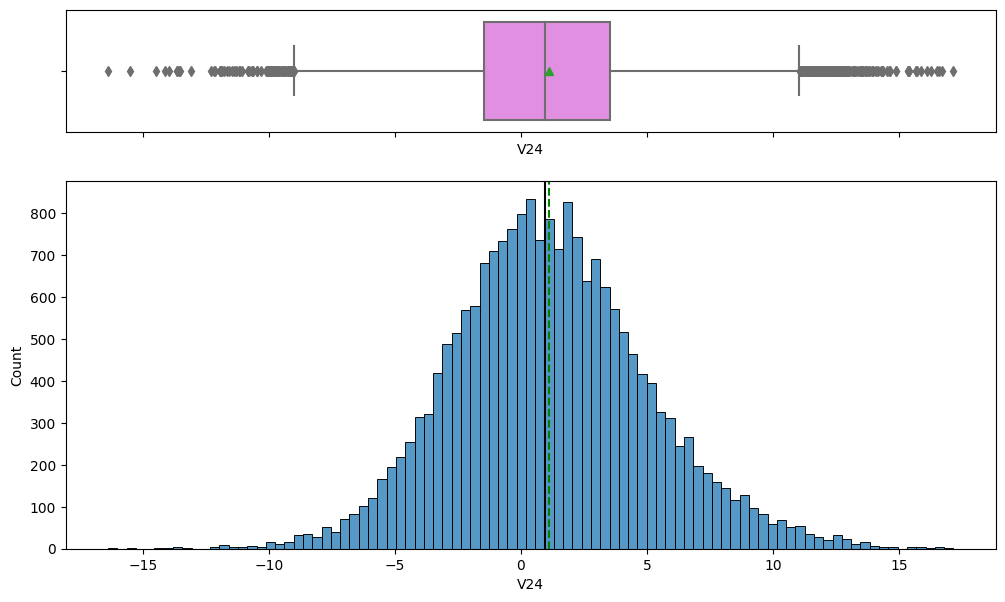

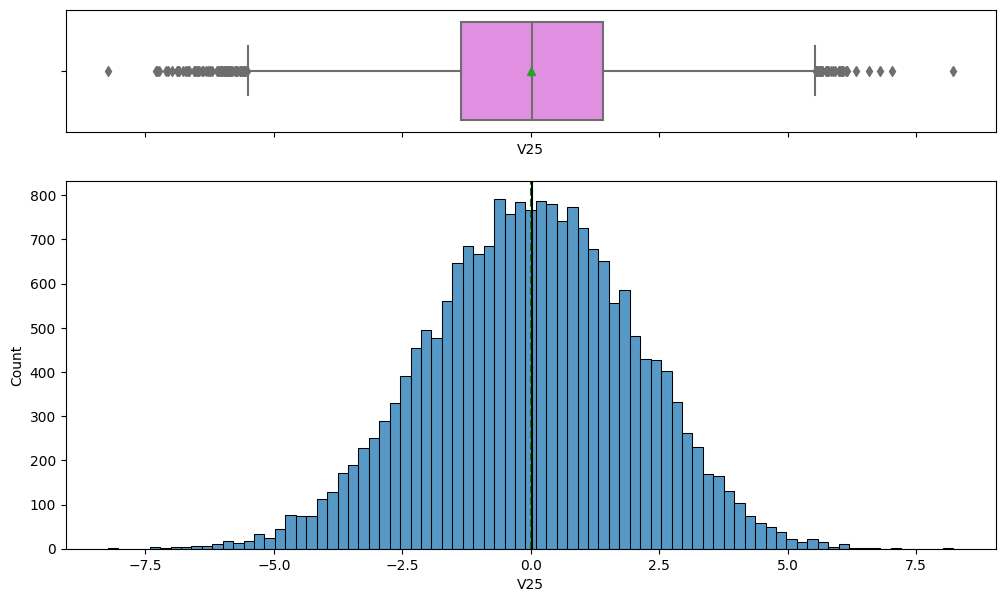

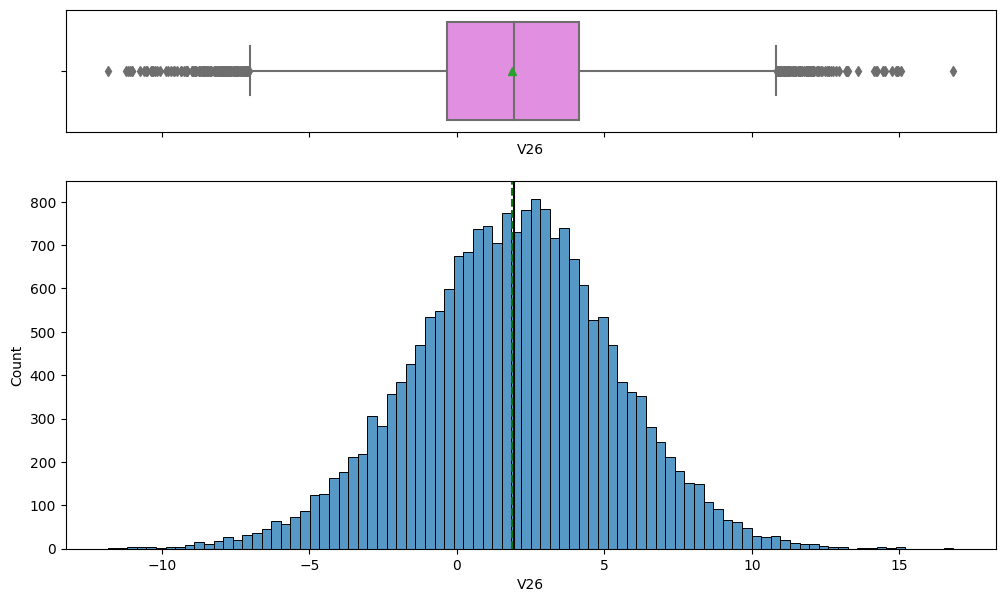

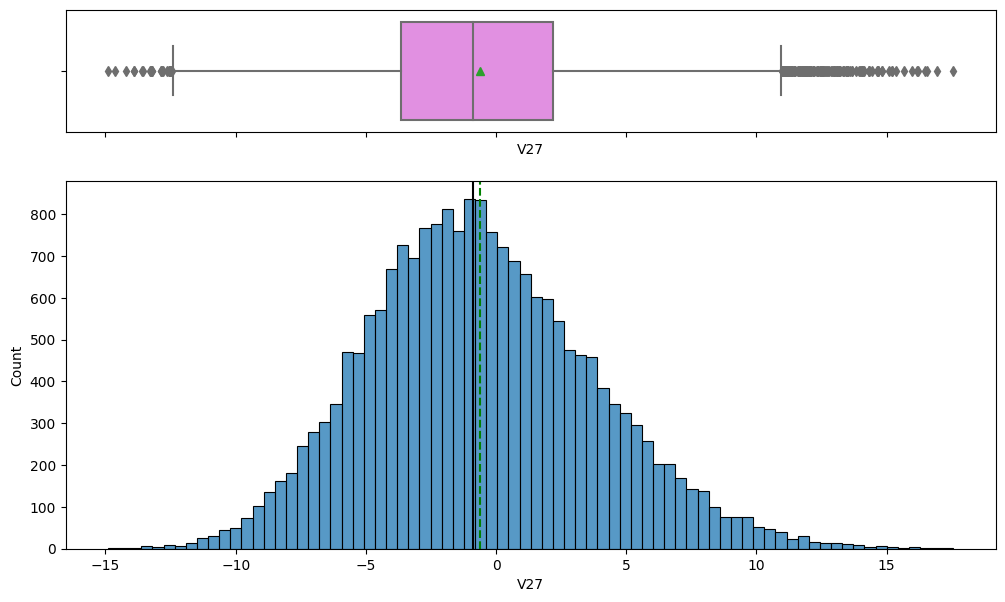

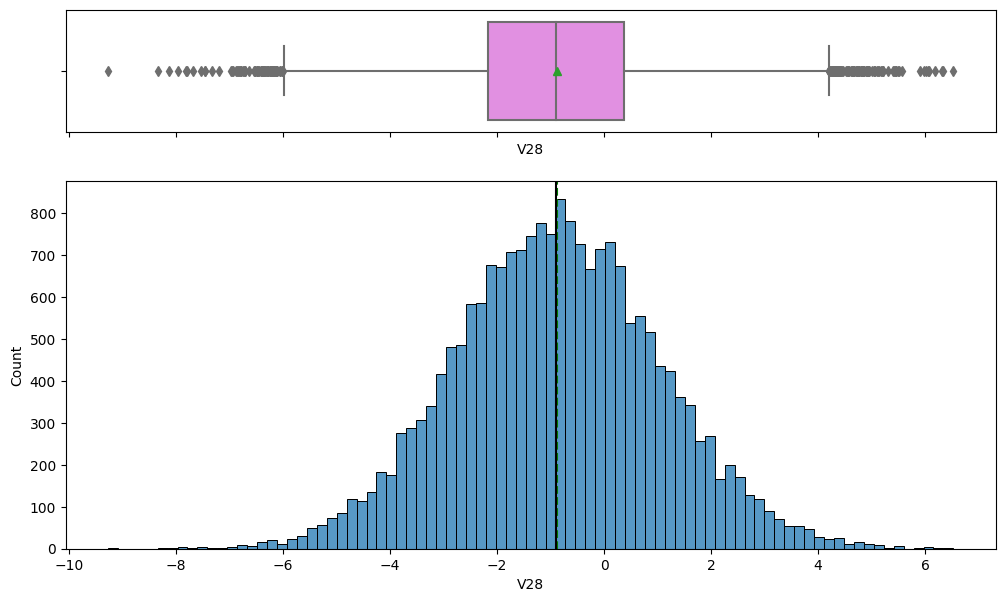

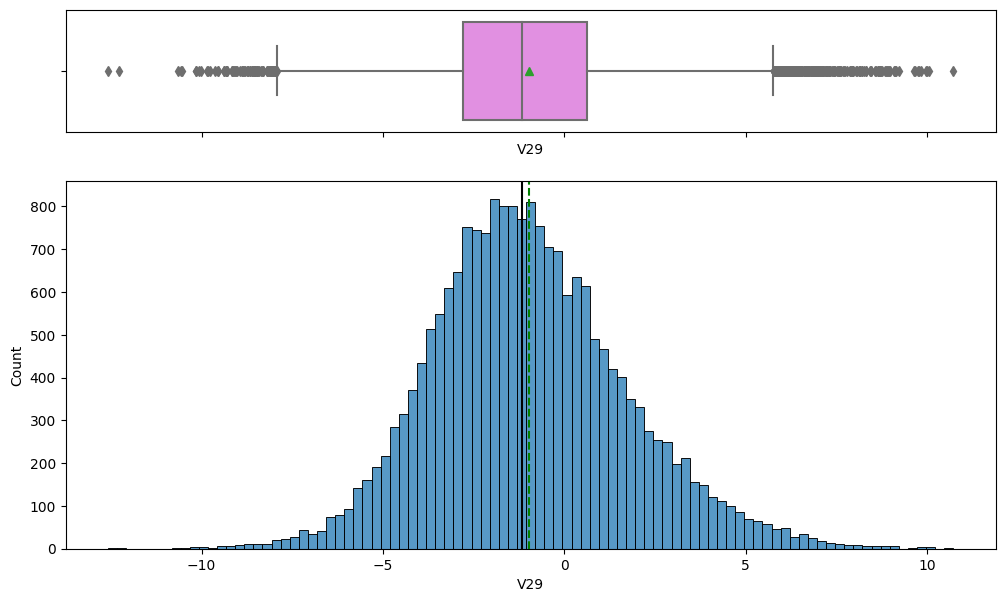

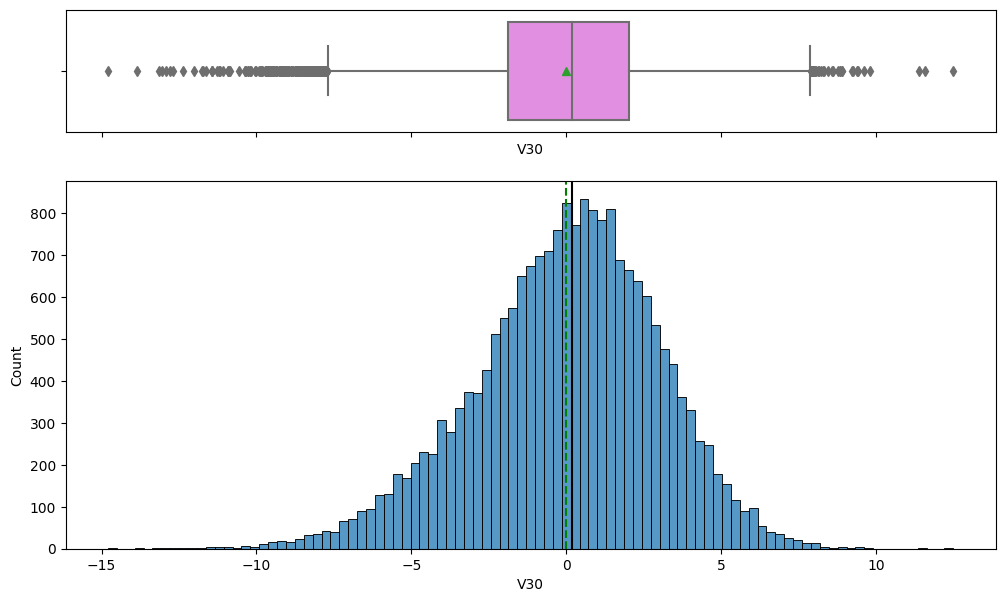

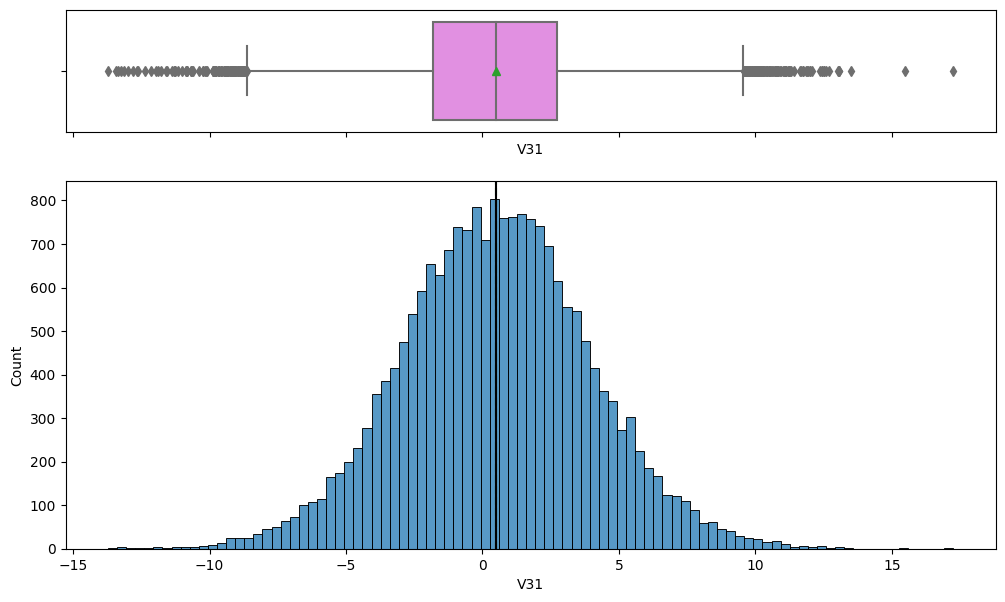

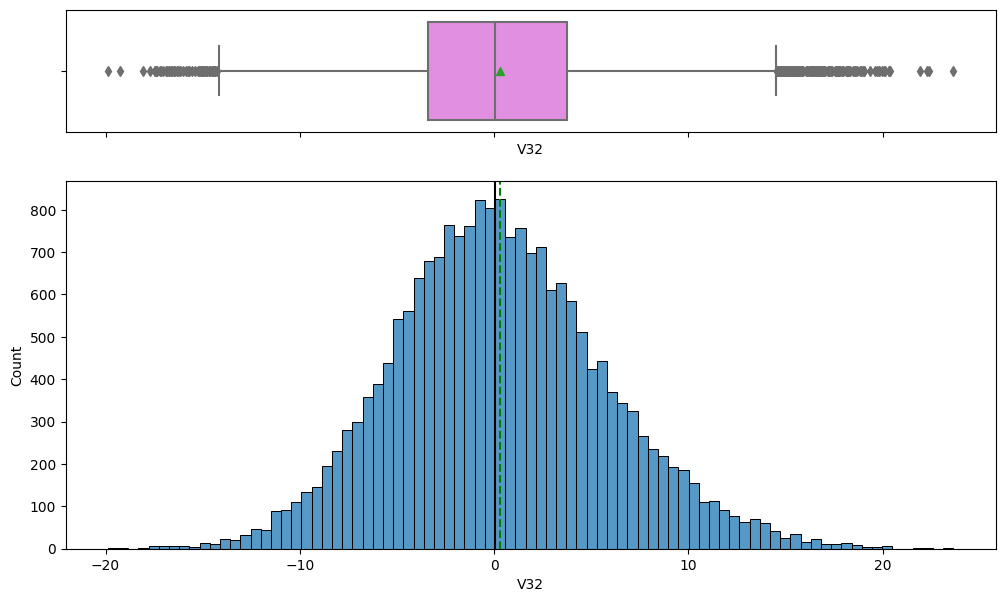

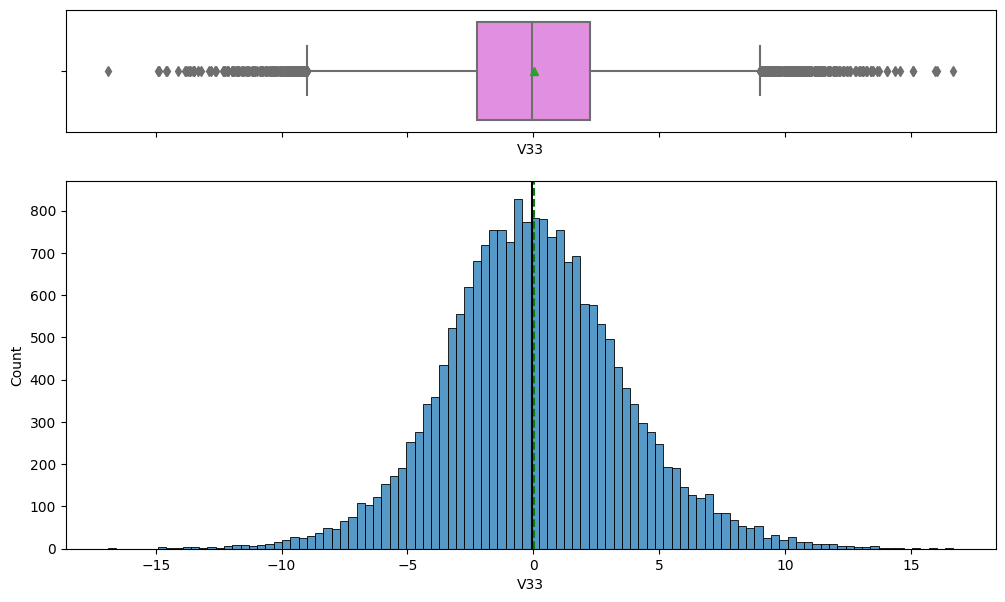

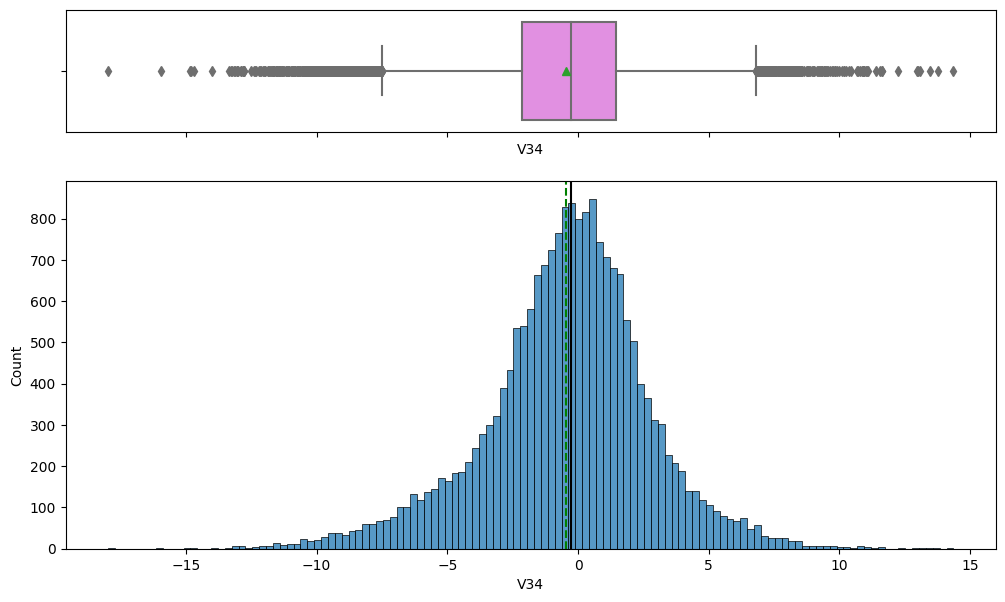

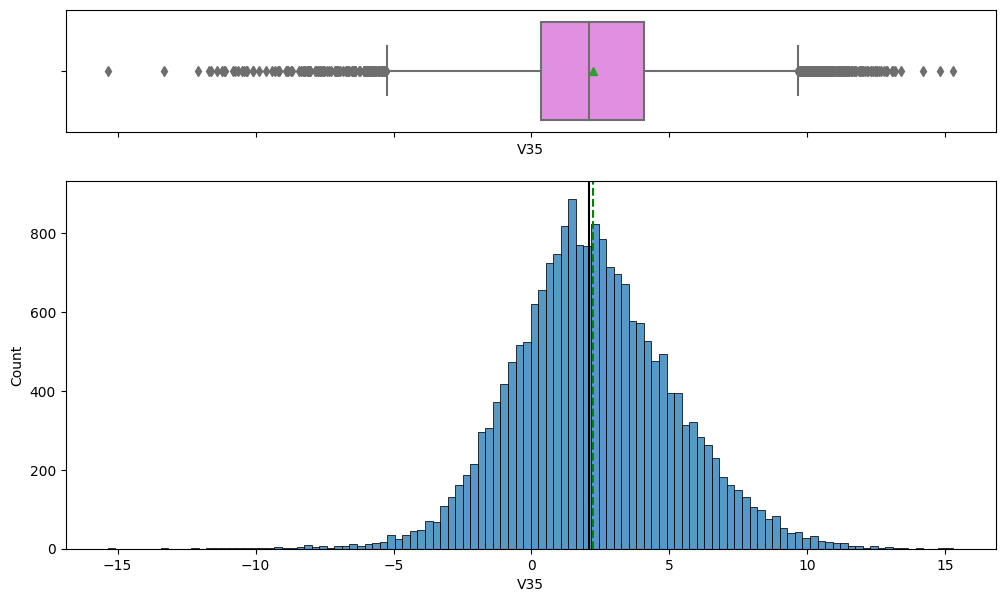

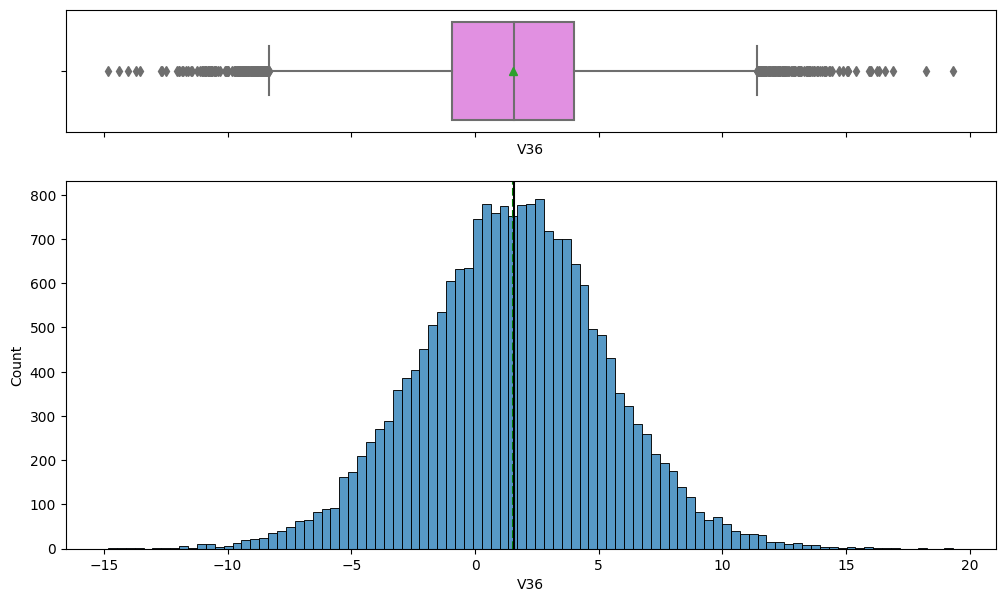

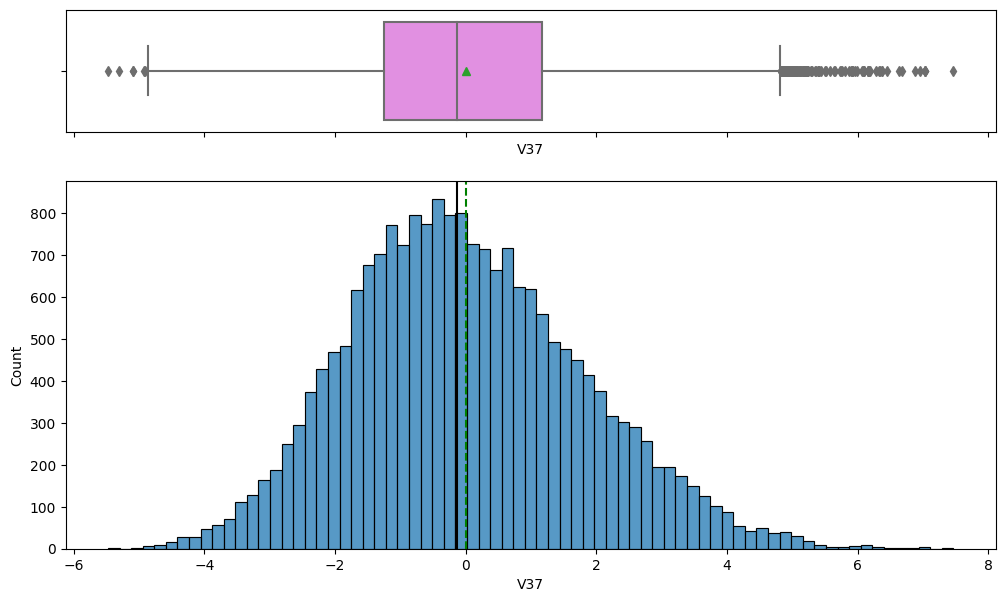

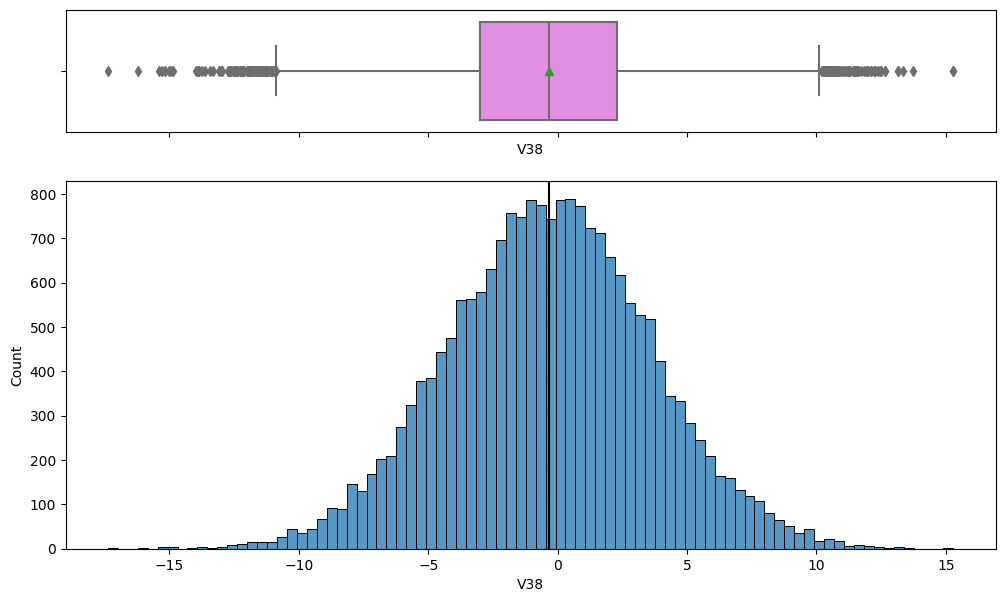

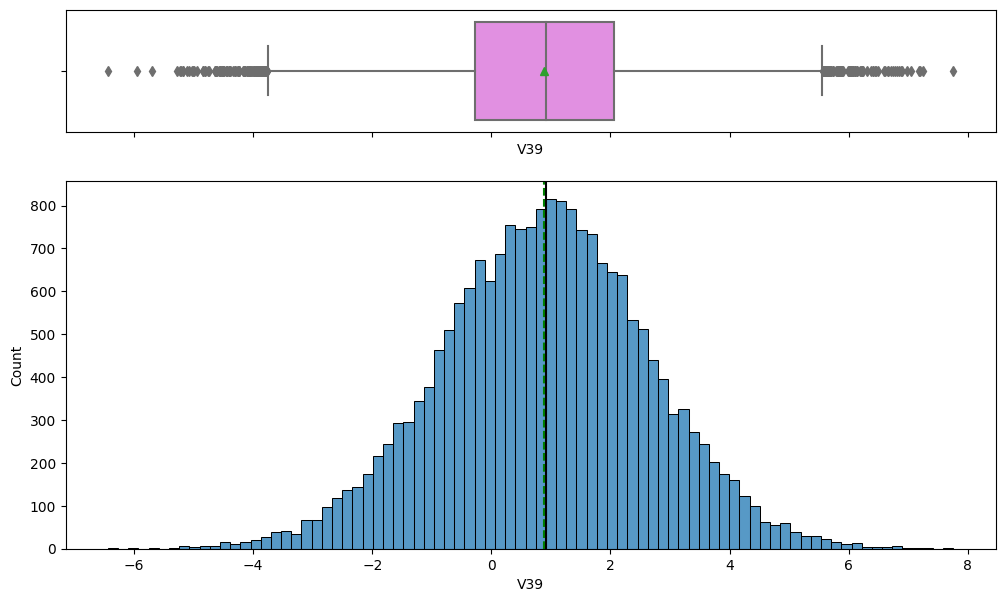

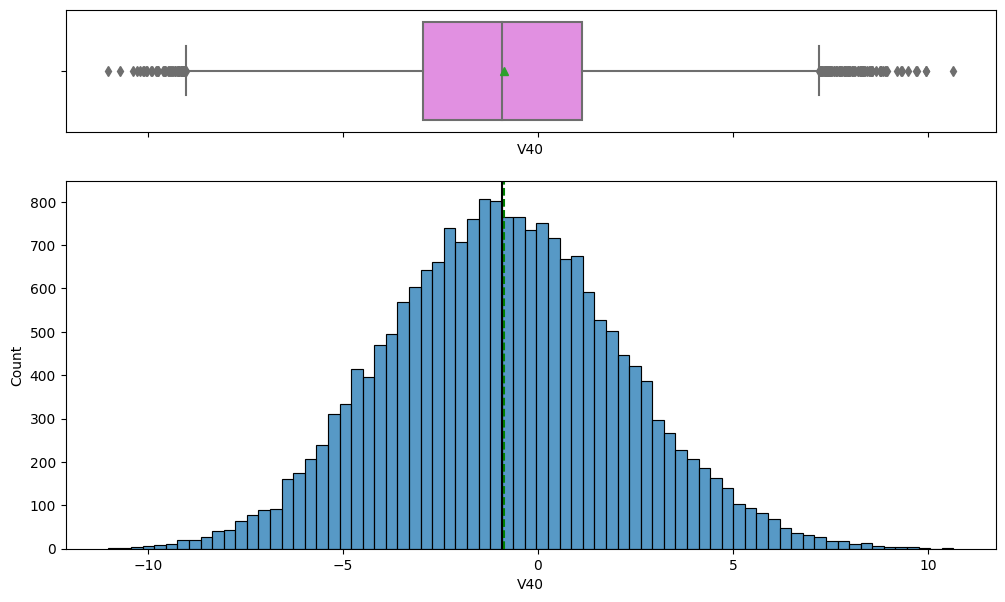

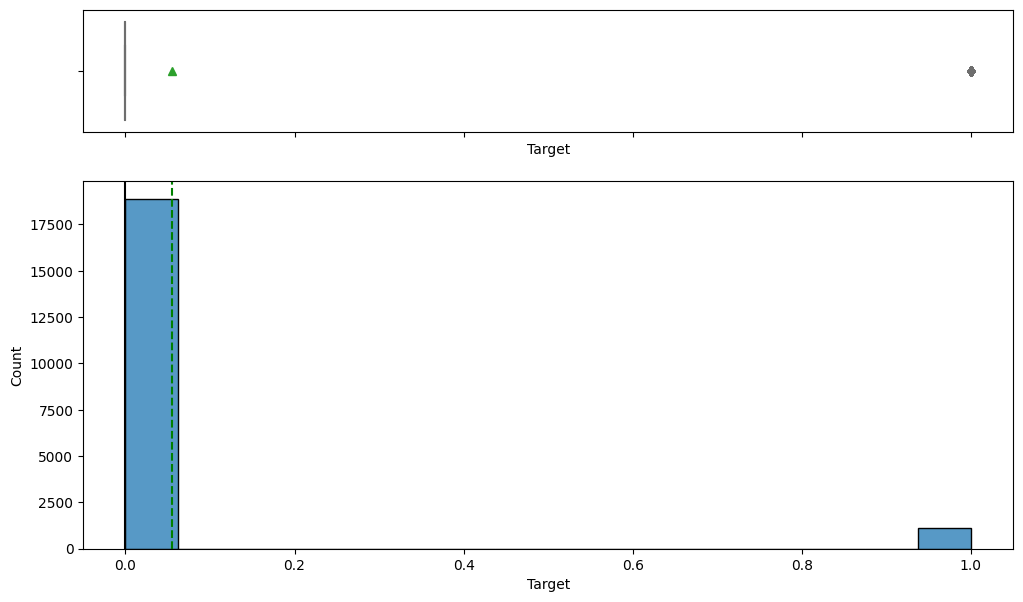

In [ ]:
for feature in data.columns:
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

- There are positive and negative outliers for all attributes "V1" to "V40". The scale of attributes are more or less the same (somewhere between -20 to +20). Since not much is known about the attributes, the outliers will not be treated and are assumed to be real data trends.

## Data Pre-processing

In [ ]:
# Split data
df = data.copy()

X = df.drop(["Target"], axis=1)
y = df["Target"]

In [ ]:
# Splitting data into training and validation sets:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape)

(14000, 40) (6000, 40)


- There are 14000 rows in the training and 6000 rows in the validation sets. 


In [ ]:
y_train.value_counts()

0    13223
1      777
Name: Target, dtype: int64

In [ ]:
y_val.value_counts()

0    5667
1     333
Name: Target, dtype: int64

- Stratify has maintained a distribution of 94.45% "No failures" or "0" and 5.55% "Failures" or "1" in both the test and validation splits.

## Missing value imputation




- We will use median to impute missing values in "V1" and "V2" columns.

In [ ]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_train)

X_train = impute.fit_transform(X_train)
X_val = imputer.transform(X_val)

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [ ]:
%%time

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4902481389578163
Bagging: 0.707808105872622
Random forest: 0.7194127377998345
GBM: 0.7220016542597187
Adaboost: 0.6434656741108354
Xgboost: 0.7979487179487179
dtree: 0.7078246484698097

Validation Performance:

Logistic regression: 0.5015015015015015
Bagging: 0.7267267267267268
Random forest: 0.7357357357357357
GBM: 0.7357357357357357
Adaboost: 0.6516516516516516
Xgboost: 0.8198198198198198
dtree: 0.7057057057057057
CPU times: user 6min 36s, sys: 840 ms, total: 6min 37s
Wall time: 5min 58s


- The cross validation training performance scores are similar to the validation perfromance score. This indicates that the default algorithms on original dataset are able to generalize well
- Just logistic regression scores are not good, so we do not need to use it again.

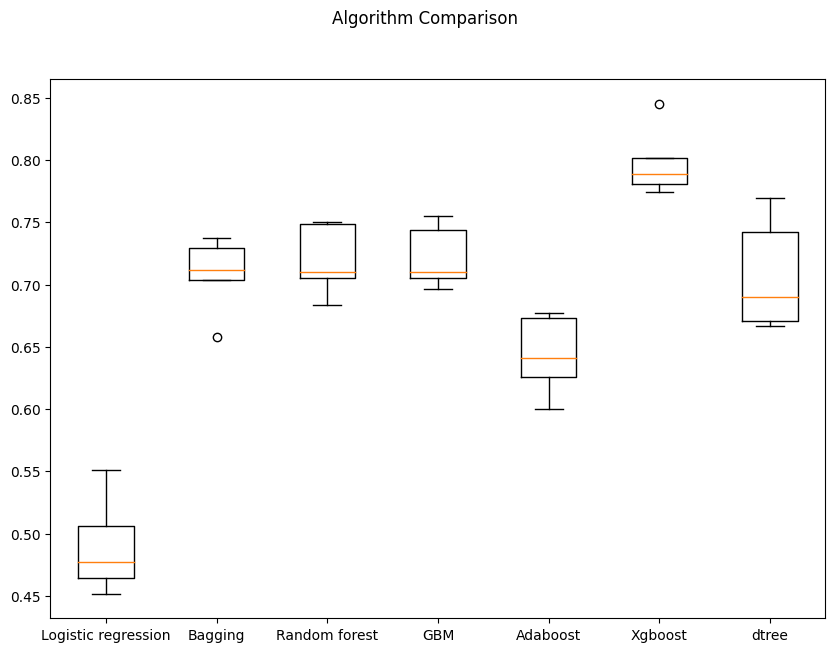

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with Oversampled data


In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 777
Before OverSampling, counts of label '0': 13223 

After OverSampling, counts of label '1': 13223
After OverSampling, counts of label '0': 13223 

After OverSampling, the shape of train_X: (26446, 40)
After OverSampling, the shape of train_y: (26446,) 



- To handle class imbalance in "Target" attribute, synthetic minority oversampling technique was employed to generate synthetic data points for minority class of importance (i.e, class "1" or No failures)
- After applying SMOTE, we have equal number of class "1" and calss "0" target outcomes

In [ ]:
%%time
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))

results_over = []  # Empty list to store all model's CV scores
names_over= []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Bagging: 0.975119441528989
Random forest: 0.9829090368319754
GBM: 0.9329201902370526
Adaboost: 0.904787470436327
Xgboost: 0.9895639018614746
dtree: 0.970128321355339

Validation Performance:

Bagging: 0.8258258258258259
Random forest: 0.8558558558558559
GBM: 0.8768768768768769
Adaboost: 0.8618618618618619
Xgboost: 0.8558558558558559
dtree: 0.7837837837837838
CPU times: user 12min 2s, sys: 751 ms, total: 12min 3s
Wall time: 10min 35s


- It is likely that the algorithms are overfitting the noise in the training sets which explains the trends in the observed performance scores (cross validation training scores ~ training score >> validation score). This will be a concern taking these models to production

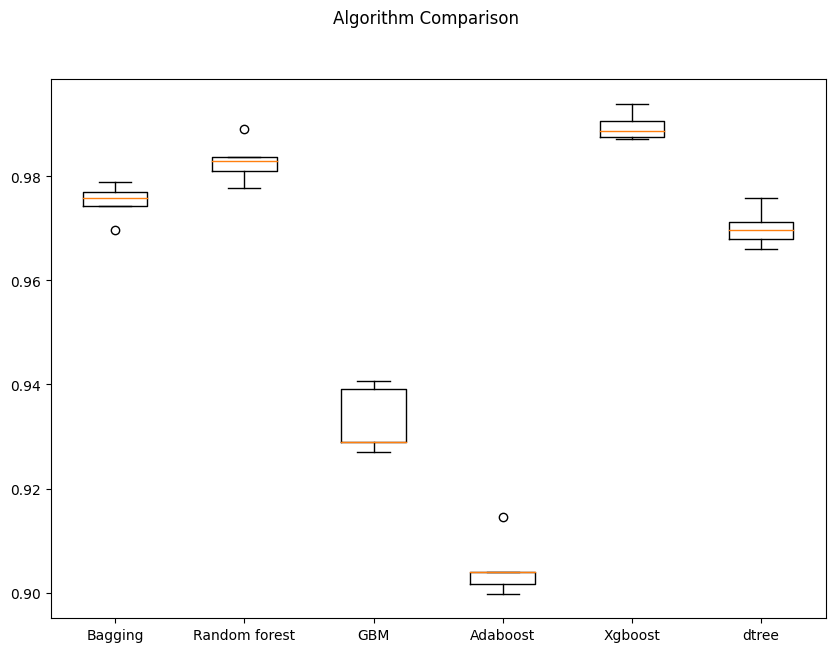

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names_over)

plt.show()


- The performance score has shown improvement on the oversampled validation dataset compared to the original dataset. 

Now, let's examine the results on the undersampled validation dataset to determine which models should proceed for hyperparameter tuning.

### Model Building with Undersampled data

In [ ]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 777
Before UnderSampling, counts of label '0': 13223 

After UnderSampling, counts of label '1': 777
After UnderSampling, counts of label '0': 777 

After UnderSampling, the shape of train_X: (1554, 40)
After UnderSampling, the shape of train_y: (1554,) 



- Another technique to handle class imbalance in "Target" attribute is random undersampling, where in only random samples from the majority class are chosen for model building. While this helps in dealing with models potentially overfitting, it can often lead to poor performing models due to "loss of information" from not considering all datapoints available
- After random undersampling, we again have equal number of class "1" and class "0" (and overall less number of datapoints for model building)

In [ ]:
%%time
models_un = []  # Empty list to store all the models

# Appending models into the list
models_un.append(("Bagging", BaggingClassifier(random_state=1)))
models_un.append(("Random forest", RandomForestClassifier(random_state=1)))
models_un.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_un.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_un.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models_un.append(("dtree", DecisionTreeClassifier(random_state=1)))

results_un = []  # Empty list to store all model's CV scores
names_un= []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_un:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_un.append(cv_result)
    names_un.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Bagging: 0.880339123242349
Random forest: 0.9034822167080232
GBM: 0.8932009925558313
Adaboost: 0.8725971877584782
Xgboost: 0.897055417700579
dtree: 0.8622167080231596

Validation Performance:

Bagging: 0.8708708708708709
Random forest: 0.8828828828828829
GBM: 0.8828828828828829
Adaboost: 0.8588588588588588
Xgboost: 0.8918918918918919
dtree: 0.8408408408408409
CPU times: user 33.5 s, sys: 85.6 ms, total: 33.6 s
Wall time: 29.6 s


- The performance score has shown a significant improvement on the undersampled validation dataset compared to the original and oversampled datasets. This suggests that the algorithms are functioning effectively. 

Consequently, it would be advisable to proceed with best 3 of these models for production, following appropriate hyperparameter tuning. They are listed next observation tab.

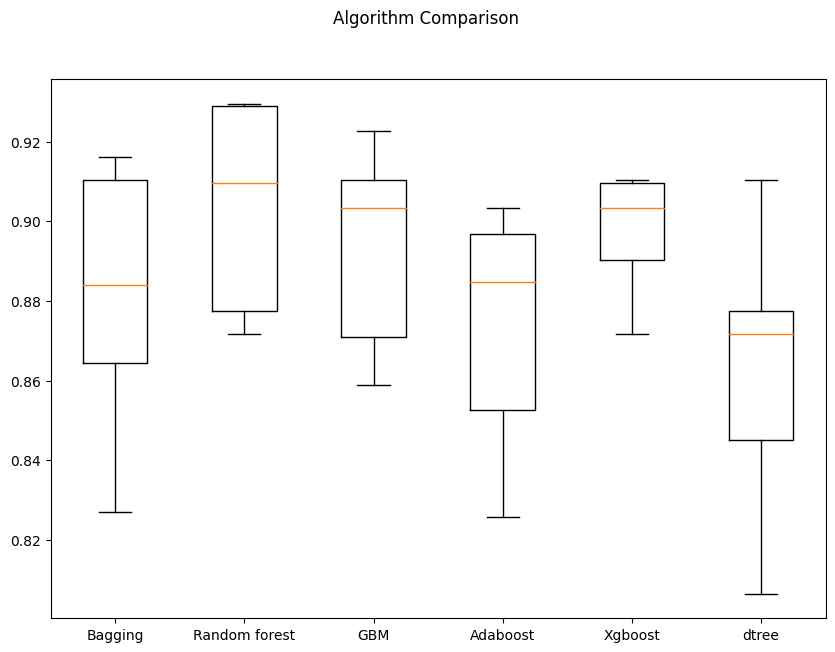

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_un)
ax.set_xticklabels(names_un)

plt.show()

**After looking at performance of all the models, let's decide which models can further improve with hyperparameter tuning.**

Upon evaluation, it was determined that the best models were obtained using undersampled data. The top three models that demonstrated exceptional performance are as follows: 

1- We should focus on optimizing the performance of **XGBoost through hyperparameter tuning, utilizing undersampled data**.

2-  Similarly, we should explore the potential of enhancing the performance of **Gradient Boosting by tuning its hyperparameters, while utilizing undersampled data**. 

3- Lastly, we can further improve the performance of **Random Forest by fine-tuning its hyperparameters, leveraging the advantages of undersampled data**. 

These three models exhibited the most favorable outcomes among all the models considered.

## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Tuning XGBoosting using undersampled data

In [ ]:
%%time 

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un) ## Complete the code to fit the model on over sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9253349875930521:
CPU times: user 7.34 s, sys: 384 ms, total: 7.72 s
Wall time: 8min 3s


In [ ]:
tuned_XGB_un=XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=200,
    learning_rate=0.1,
    gamma=5,
)

tuned_XGB_un.fit(X_train_un,y_train_un) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [ ]:
tuned_XGB_un_train_perf= model_performance_classification_sklearn(
    tuned_XGB_un, X_train_un, y_train_un
)
print("Training performance:")
tuned_XGB_un_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.992,1.000,0.985,0.992


In [ ]:
tuned_XGB_un_val_perf=model_performance_classification_sklearn(
    tuned_XGB_un, X_val, y_val
)
print("Validation performance:")
tuned_XGB_un_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.867,0.904,0.281,0.429


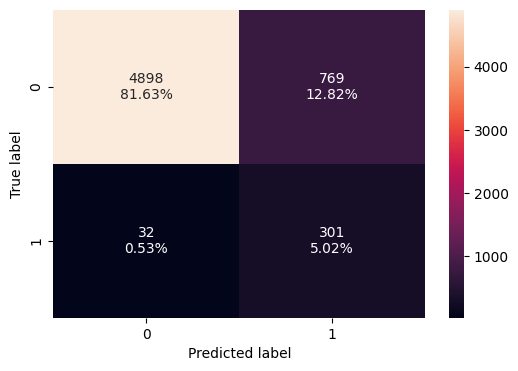

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_XGB_un, X_val, y_val)

- The best hyperparameters using RandomizedSearch CV for XGBoost model were found to be: subsample 0.8, scale_pos_weight 10, n_estimators 200, learning_rate 0.1 and gamma 5.
- Recall score is very well for now on validation data. 0.904

###Tuning Gradient Boosting (GBM) using undersampled data

In [ ]:
%%time 

# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV

param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

#param_grid={"n_estimators": np.arange(50,150,25), "learning_rate": [0.2,0.01, 0.05, 1], "subsample":[0.3,0.4,0.5,0.7,0.6], "max_features":[0.3,0.4,0.5,0.6,0.7]}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.05} with CV score=0.9047394540942928:
CPU times: user 1.85 s, sys: 75.3 ms, total: 1.93 s
Wall time: 1min 22s


In [ ]:
# Creating new pipeline with best parameters
tuned_gbm_un = GradientBoostingClassifier(
    max_features=0.7,
    random_state=1,
    learning_rate=0.05,
    n_estimators=100,
    subsample=0.7
)

tuned_gbm_un.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.05, max_features=0.7, random_state=1,
                           subsample=0.7)

In [ ]:
tuned_GBM_un_train_perf= model_performance_classification_sklearn(
    tuned_gbm_un, X_train_un, y_train_un
)
print("Training performance:")
tuned_GBM_un_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.947,0.920,0.973,0.946


In [ ]:
tuned_GBM_un_val_perf=model_performance_classification_sklearn(
    tuned_gbm_un, X_val, y_val
)
print("Validation performance:")
tuned_GBM_un_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.920,0.871,0.401,0.549


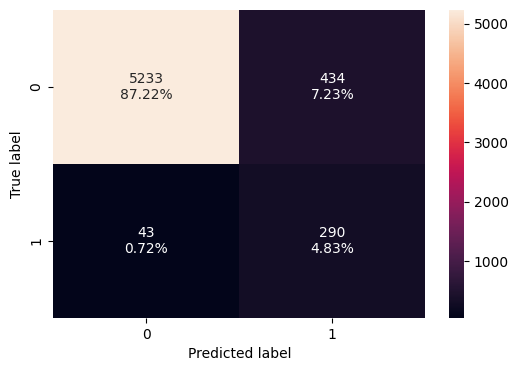

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_gbm_un, X_val, y_val)

- The best hyperparameters using RandomizedSearch CV for GBM model were found to be: 'subsample': 0.7, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.05.
- Recall score is well on validation data. (0.871)

###Tuning Random Forest using undersampled data

In [ ]:
%%time 

# defining model
Model = RandomForestClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }




#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9047477253928868:
CPU times: user 2.87 s, sys: 108 ms, total: 2.98 s
Wall time: 1min 56s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf_un = RandomForestClassifier(
    random_state=1,
    n_estimators=300,
    min_samples_leaf=1,
    max_samples=0.6,
    max_features='sqrt'
    
)

tuned_rf_un.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

In [ ]:
tuned_RF_un_train_perf= model_performance_classification_sklearn(
    tuned_rf_un, X_train_un, y_train_un
)
print("Training performance:")
tuned_RF_un_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.988,0.978,0.999,0.988


In [ ]:
tuned_RF_un_val_perf=model_performance_classification_sklearn(
    tuned_rf_un, X_val, y_val
)
print("Validation performance:")
tuned_RF_un_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.934,0.880,0.451,0.597


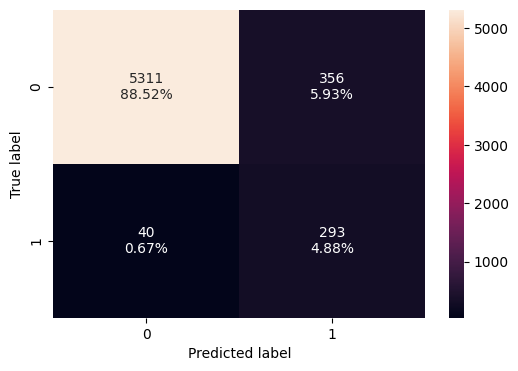

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf_un, X_val, y_val)

- The best hyperparameters using RandomizedSearch CV for RF model were found to be: 'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'.
- Recall score is well on validation data. (0.880)

## Model performance comparison and choosing the final model

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [tuned_XGB_un_train_perf.T, tuned_GBM_un_train_perf.T, tuned_RF_un_train_perf.T,], axis=1,
)
models_train_comp_df.columns = [
    "Tuning XGBoosting using undersampled data",
    "Tuning Gradient Boosting using undersampled data",
    "Tuning Random Forest using undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Tuning XGBoosting using undersampled data,Tuning Gradient Boosting using undersampled data,Tuning Random Forest using undersampled data
Accuracy,0.992,0.947,0.988
Recall,1.000,0.920,0.978
Precision,0.985,0.973,0.999
F1,0.992,0.946,0.988


In [ ]:
# Validation performance comparison

models_val_comp_df= pd.concat(
    [tuned_XGB_un_val_perf.T, tuned_GBM_un_val_perf.T, tuned_RF_un_val_perf.T,], axis=1,
)
models_val_comp_df.columns = [
    "Tuning XGBoosting using undersampled data",
    "Tuning Gradient Boosting using undersampled data",
    "Tuning Random Forest using undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Tuning XGBoosting using undersampled data,Tuning Gradient Boosting using undersampled data,Tuning Random Forest using undersampled data
Accuracy,0.867,0.920,0.934
Recall,0.904,0.871,0.880
Precision,0.281,0.401,0.451
F1,0.429,0.549,0.597


- The Tuning XGBoosting using undersampled data model with Random Search is giving the highest performance score (Recall) of 0.904 on the Validation Set. Although this algorithm is giving higher performance on training set (1).
- We will choose this tuned model to see if it can generalize well on the testing dataset to give a likewise high performance score (Recall) ~ 0.9.

### Test set final performance

In [ ]:
# Loading the dataset
test = pd.read_csv("/content/drive/MyDrive/Data Science- GL/6- Model Tuning/Project 6: Model Tuning : ReneWind/Test.csv")

In [ ]:
X_test = test.drop(["Target"], axis=1)
y_test = test["Target"]

In [ ]:
y_test.value_counts()

0    4718
1     282
Name: Target, dtype: int64

- The test data has likewise 94.45% "0" or "No failures" and 5.55% "1" or "Failures"

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

- There are 5 & 6 missing values for attributes "V1" and "V2". Total 11 missing values.

In [ ]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_test)
X_test = imputer.transform(X_test)

In [ ]:
XGB_test = model_performance_classification_sklearn(tuned_XGB_un, X_test, y_test)
print("Test performance:")
XGB_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.862,0.894,0.276,0.421


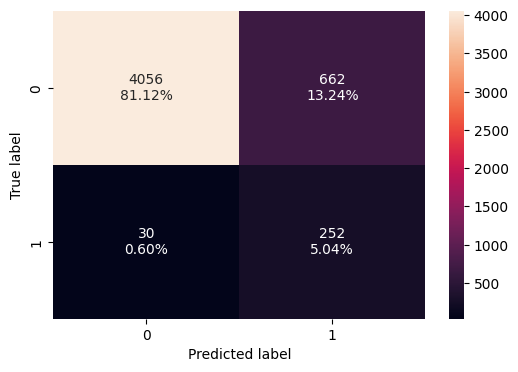

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_XGB_un, X_test, y_test)

- The Tuning XGBoosting using undersampled data model is generalizing well on the test data with a Recall of 0.894 (the cross validation training average score was 1 and the validation score was 0.904).

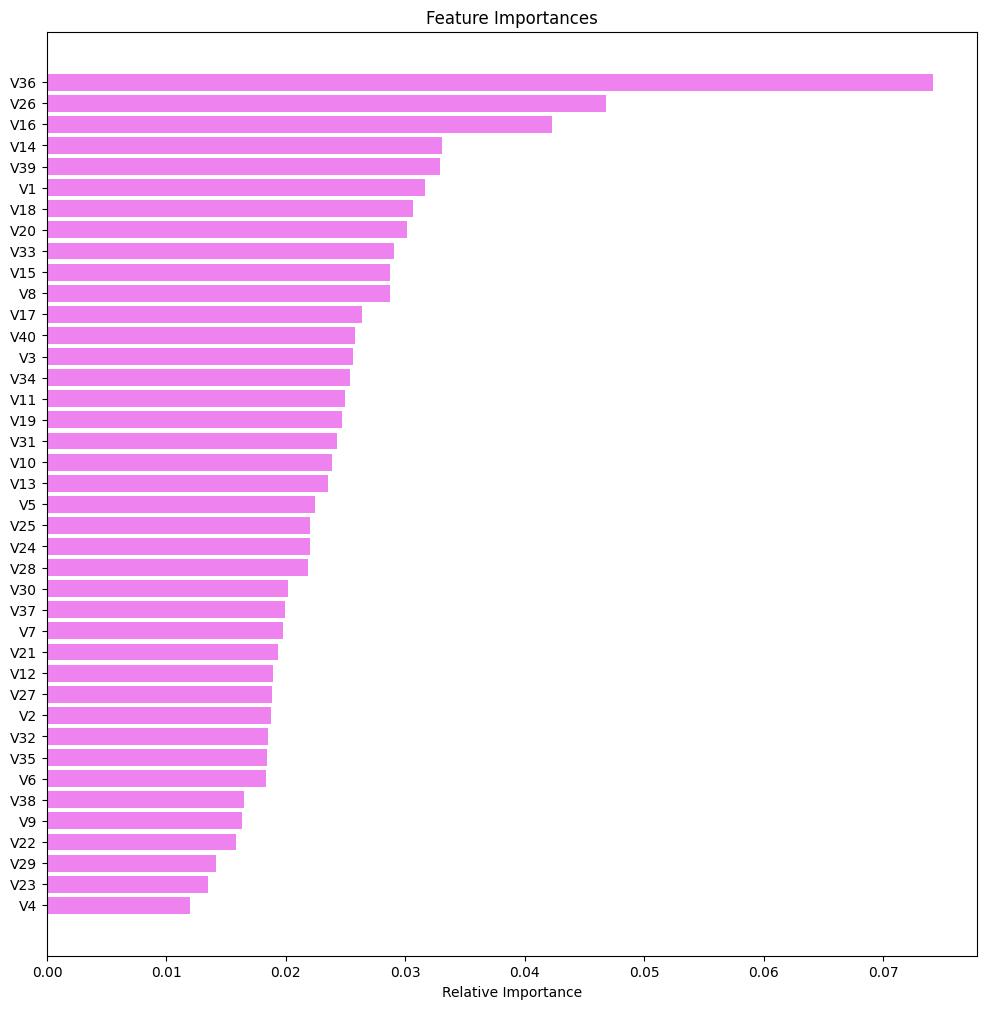

In [ ]:
feature_names = data.columns
importances = tuned_XGB_un.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- The top 5 attributes which have the maximum importance for making accurate failure/ no-failure predictions are "V36", "V26", "V16", "V14" & "V39".

## Pipelines to build the final model


- Pipelines can be used to put the final model in production



In [ ]:
# As we already know the final model, we will not be splitting train set into train and validation sets

X_train_pipeline = train.drop("Target", axis=1)
y_train_pipeline = train["Target"]

In [ ]:
X_test_pipeline = test.drop("Target", axis=1)
y_test_pipeline = test["Target"]

In [ ]:
model_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "Tuning_XGBoosting_using_undersampled",
            XGBClassifier(
            random_state=1,
            eval_metric="logloss",
            subsample=0.8,
            scale_pos_weight=10,
            n_estimators=200,
            learning_rate=0.1,
            gamma=5,
            ),
         )
    ]
)
# Fit the model on training data
model_pipeline.fit(X_train_pipeline, y_train_pipeline)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('Tuning_XGBoosting_using_undersampled',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=1, ...))])

In [ ]:
# transforming and predicting on test data
model_pipeline.predict(X_test_pipeline)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
recall_score(y_test_pipeline, model_pipeline.predict(X_test_pipeline))

0.851063829787234

In [ ]:
Model_test = model_performance_classification_sklearn(model_pipeline, X_test, y_test)
Model_test

,Accuracy,Recall,Precision,F1
0,0.989,0.851,0.941,0.894


- The pipeline performance is as expected (Recall 0.851) indicating it was built accurately to replicate the final chosen model after necessary pre processing

# Business Insights and Conclusions

- An advanced machine learning model has been developed to minimize the overall maintenance cost associated with machinery and processes utilized for wind energy production.

  * To optimize the model's accuracy in predicting generator failures and reduce maintenance costs, we must select a metric that maximizes Recall, ensuring the highest number of correct predictions and minimizing false negatives.

  * Out of approximately seven different machine learning algorithms that were tested, the final tuned model, known as Tuning_XGBoosting_using_undersampled, was selected. This choice was made after further optimization to address the class imbalance in the target variable, which involved handling a small number of "failures" and a large number of "no failures" within the dataset. Additionally, the algorithm's performance was fine-tuned using hyperparameter tuning and cross-validation techniques.

  * A pipeline was additionally built to productionise the final chosen model.

- The model is expected to exhibit strong generalization capabilities, particularly in terms of Recall. Consequently, its implementation in production offers significant cost-saving benefits.

- Through extensive analysis, the most influential attributes for predicting failures versus no failures were determined to be "V36," "V26," "V16," "V14," and "V39," listed in decreasing order of importance. This valuable insight can be leveraged to enhance the process of gathering sensor information at more frequent intervals. The collected data can then be used to improve the machine learning model further, ultimately leading to a reduction in maintenance costs.